In [1]:
!nvidia-smi

Fri Mar 14 23:08:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#!pip install tensorflow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import libraries

In [3]:
import tensorflow as tf # Access to models, datasets and training
from tensorflow.keras.datasets import cifar100 # Access to CIFAR-100
from tensorflow.keras.applications import ResNet50 # Access to pre-trained model
from tensorflow.keras import layers, models, optimizers # Access to building blocks of a model
from tensorflow.keras.models import load_model # Ability to load best_saved model
from tensorflow import keras # Access to stuff for model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split # To help split dataset up
from sklearn.metrics import confusion_matrix, classification_report # Analysis of model train, val & test
import numpy as np # Manipulate data
import pandas as pd # Statistical analysis of data
import seaborn as sns
import matplotlib.pyplot as plt # Plot data

# Function definitions

In [4]:
def display_imgs(imgs, labels):
        plt.subplots(figsize=(10,10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.imshow(imgs[k])
            #plt.title(labels[k])
            plt.axis('off')
        plt.tight_layout()
        plt.show()


def class_distrib(y, labels_names, dataset_name):
        counts = pd.DataFrame(data=y).value_counts().sort_index()
        #print(f"counts:\n{counts}")
        fig, ax = plt.subplots(figsize=(20,10))
        ax.bar(labels_names, counts)
        ax.set_xticklabels(labels_names, rotation=90, fontsize=15)
        plt.title(f"Distribution of '{dataset_name}' Dataset", fontsize=25)
        plt.grid()
        plt.tight_layout()
        plt.show()

def augment_dataset(x, y):
        x = tf.image.resize(x, (224, 224))  # Resize images
        x = tf.image.random_flip_left_right(x)  # Random horizontal flip
        x = tf.image.random_brightness(x, max_delta=0.2)  # Adjust brightness
        x = tf.image.random_contrast(x, lower=0.8, upper=1.2)  # Adjust contrast
        y = tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))  # One-hot encode labels
        return x, y

def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
        # Plot Training and Validation Loss
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid()

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()


# Dropout(0.7), weight_decay(3e-1), l2(3e-1)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[1070].shape: (1,)
imgs[1070].shape: (32, 32, 3)


labels[36059].shape: (1,)
imgs[36059].shape: (32, 32, 3)


<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


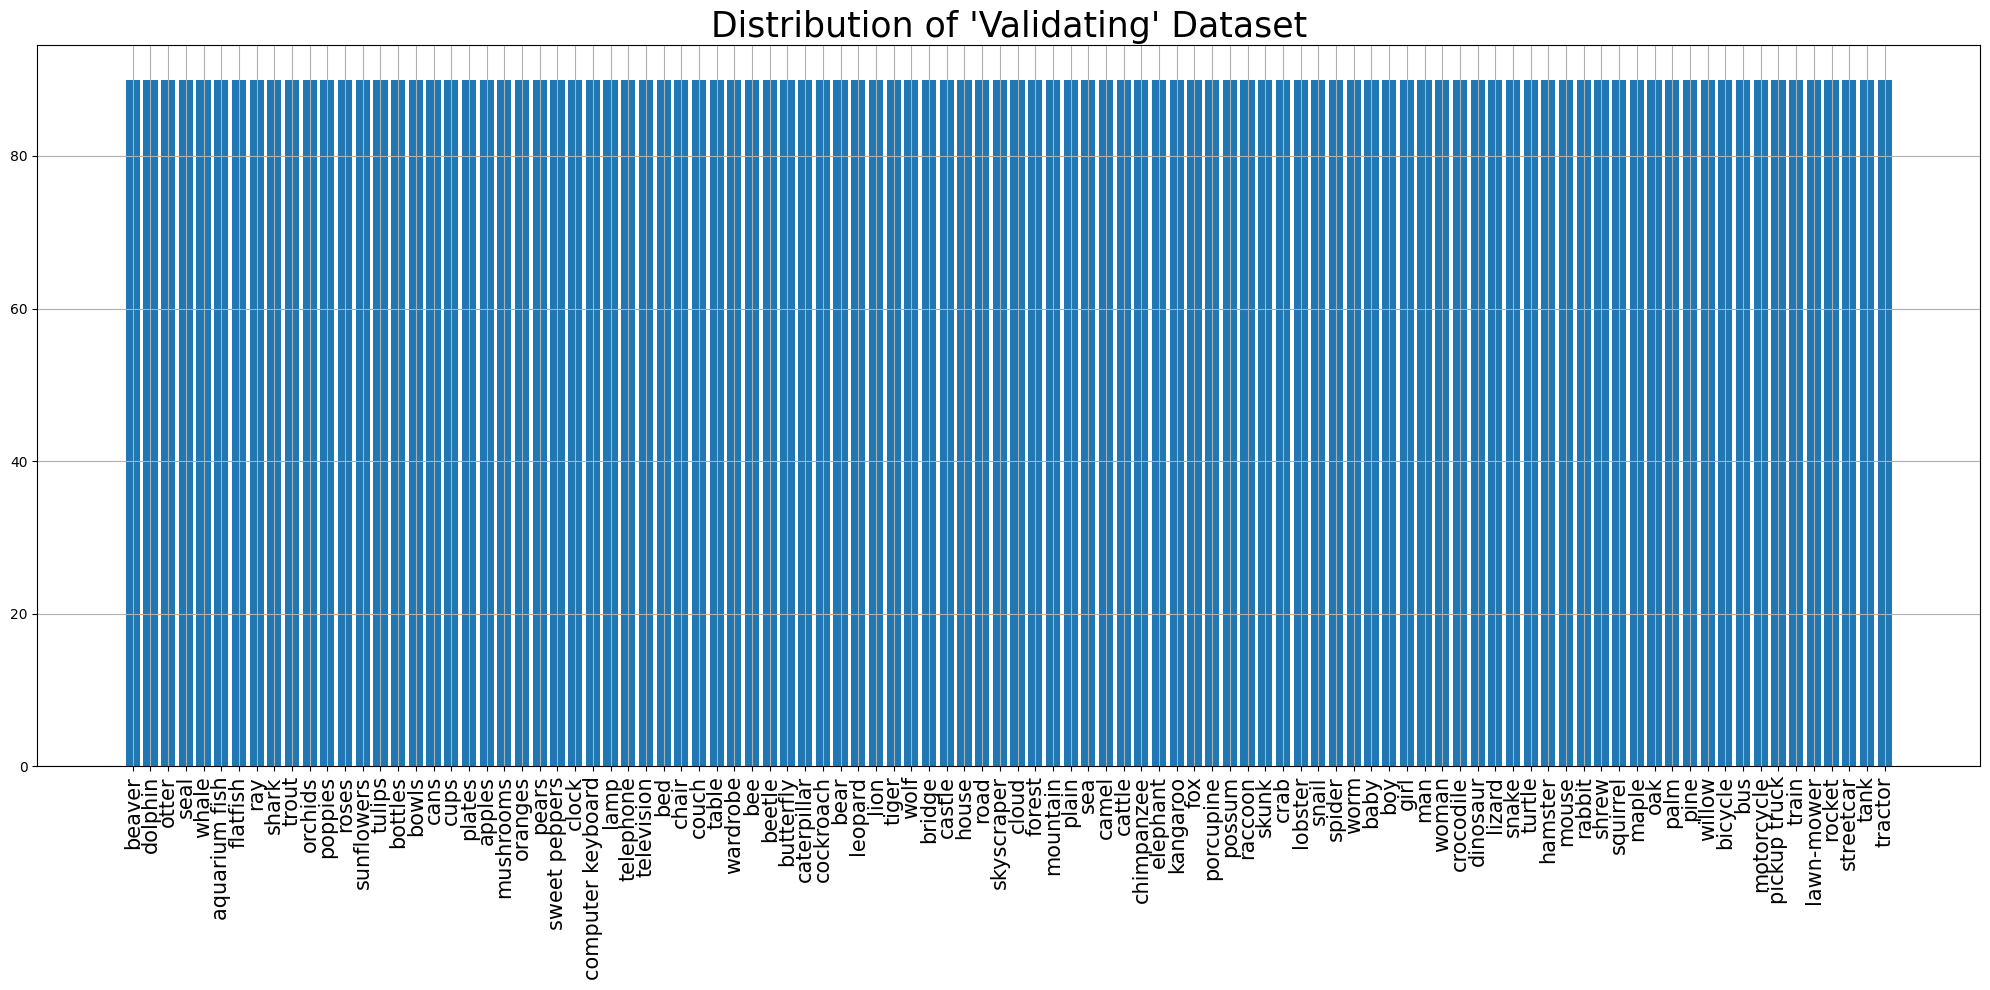

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


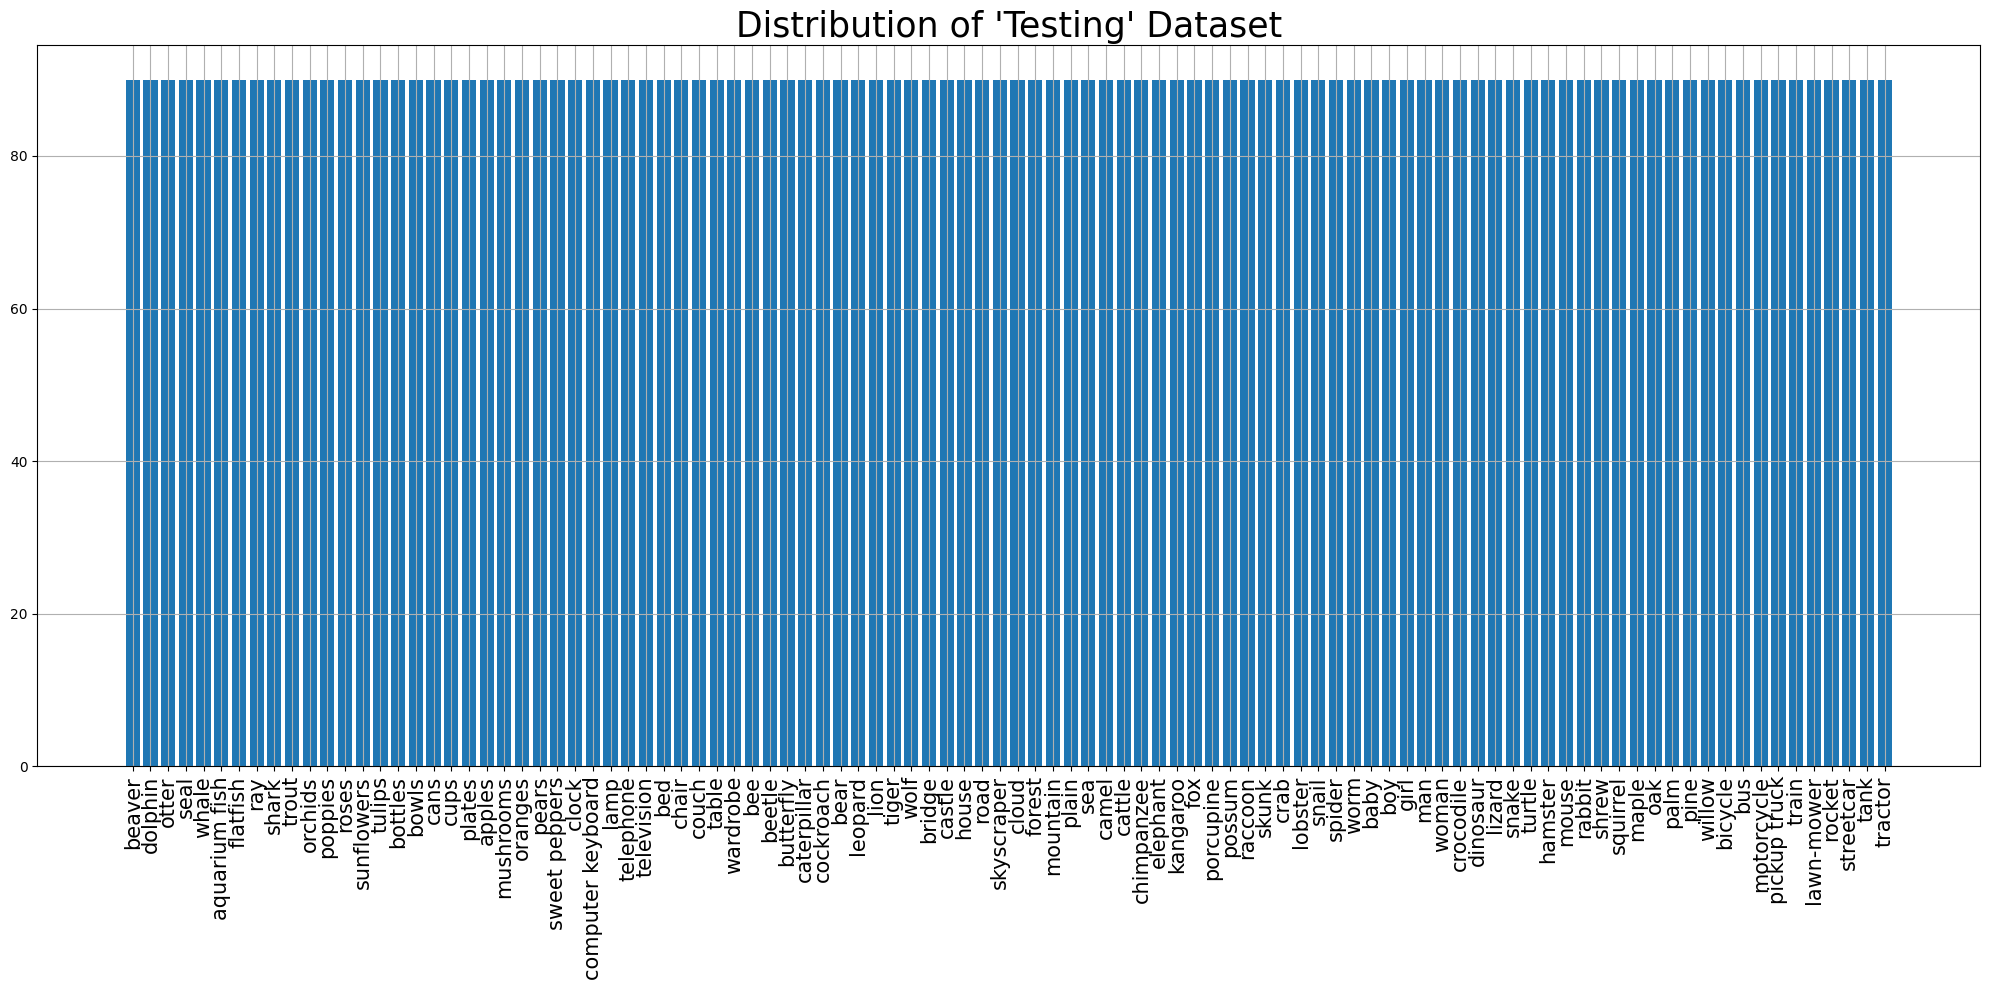

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.nda

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2654 - f1_score: 0.2594 - loss: 3.1989 - precision: 0.6251
Epoch 1: val_loss improved from inf to 1.58182, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 56s 58ms/step - accuracy: 0.2656 - f1_score: 0.2595 - loss: 3.1979 - precision: 0.6252 - val_accuracy: 0.5690 - val_f1_score: 0.5634 - val_loss: 1.5818 - val_precision: 0.8273
Epoch 2/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4726 - f1_score: 0.4674 - loss: 1.9409 - precision: 0.7259
Epoch 2: val_loss improved from 1.58182 to 1.47065, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.4727 - f1_score: 0.4674 - loss: 1.9406 - precision: 0.7259 - val_accuracy: 0.5936 - val_f1_score: 0.5904 - val_loss: 1.4706 - val_precision: 0.8419
Epoch 3/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5125 - f1_score: 0.5078 - loss: 1.7824 - precision: 0.7479
Epoch 3: val_loss improved from 1.47065 

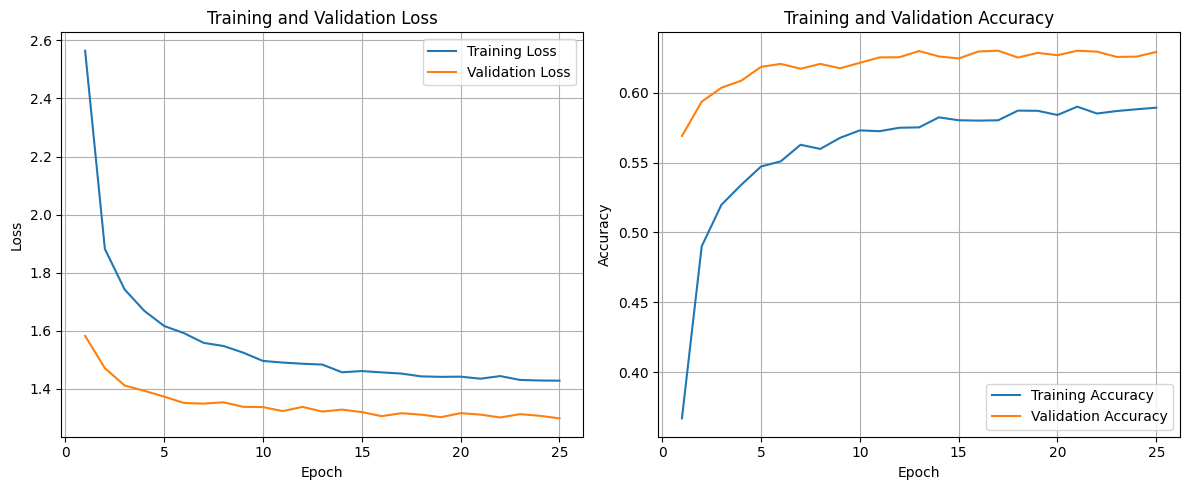

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6236 - f1_score: 0.6156 - loss: 1.3137 - precision: 0.8200
Test Accuracy: 63.22%
Test Loss: 1.2902672290802002
Test Precision: 82.56%
Test F1 Scores (Per Class): [84.57142  72.94117  52.808983 41.134747 31.578945 58.227837 56.302513
 64.2857   80.459755 80.21977  56.521732 40.71856  63.75     53.89221
 66.666664 58.252422 80.459755 71.42857  55.81395  57.142853 82.53968
 73.11827  80.473366 75.93583  73.56321  57.819897 44.85981  47.12643
 75.72816  67.48465  59.602642 68.0851   48.61878  48.818893 67.83625
 18.348621 69.135796 57.309933 47.66839  89.41175  70.17543  81.87134
 61.437904 71.35134  46.31578  39.13043  50.22421  50.833332 81.52173
 79.99999  39.999996 69.047615 62.433857 85.88235  67.796616 33.720924
 80.92485  71.71716  70.83333  45.80152  77.34807  73.19587  62.962955
 65.88235  45.45454  54.411762 65.11627  57.80347  84.37499  86.516846
 63.681583 68.13186  40.59405  58.139526 35.63218  80.66298  84.491974
 58.62

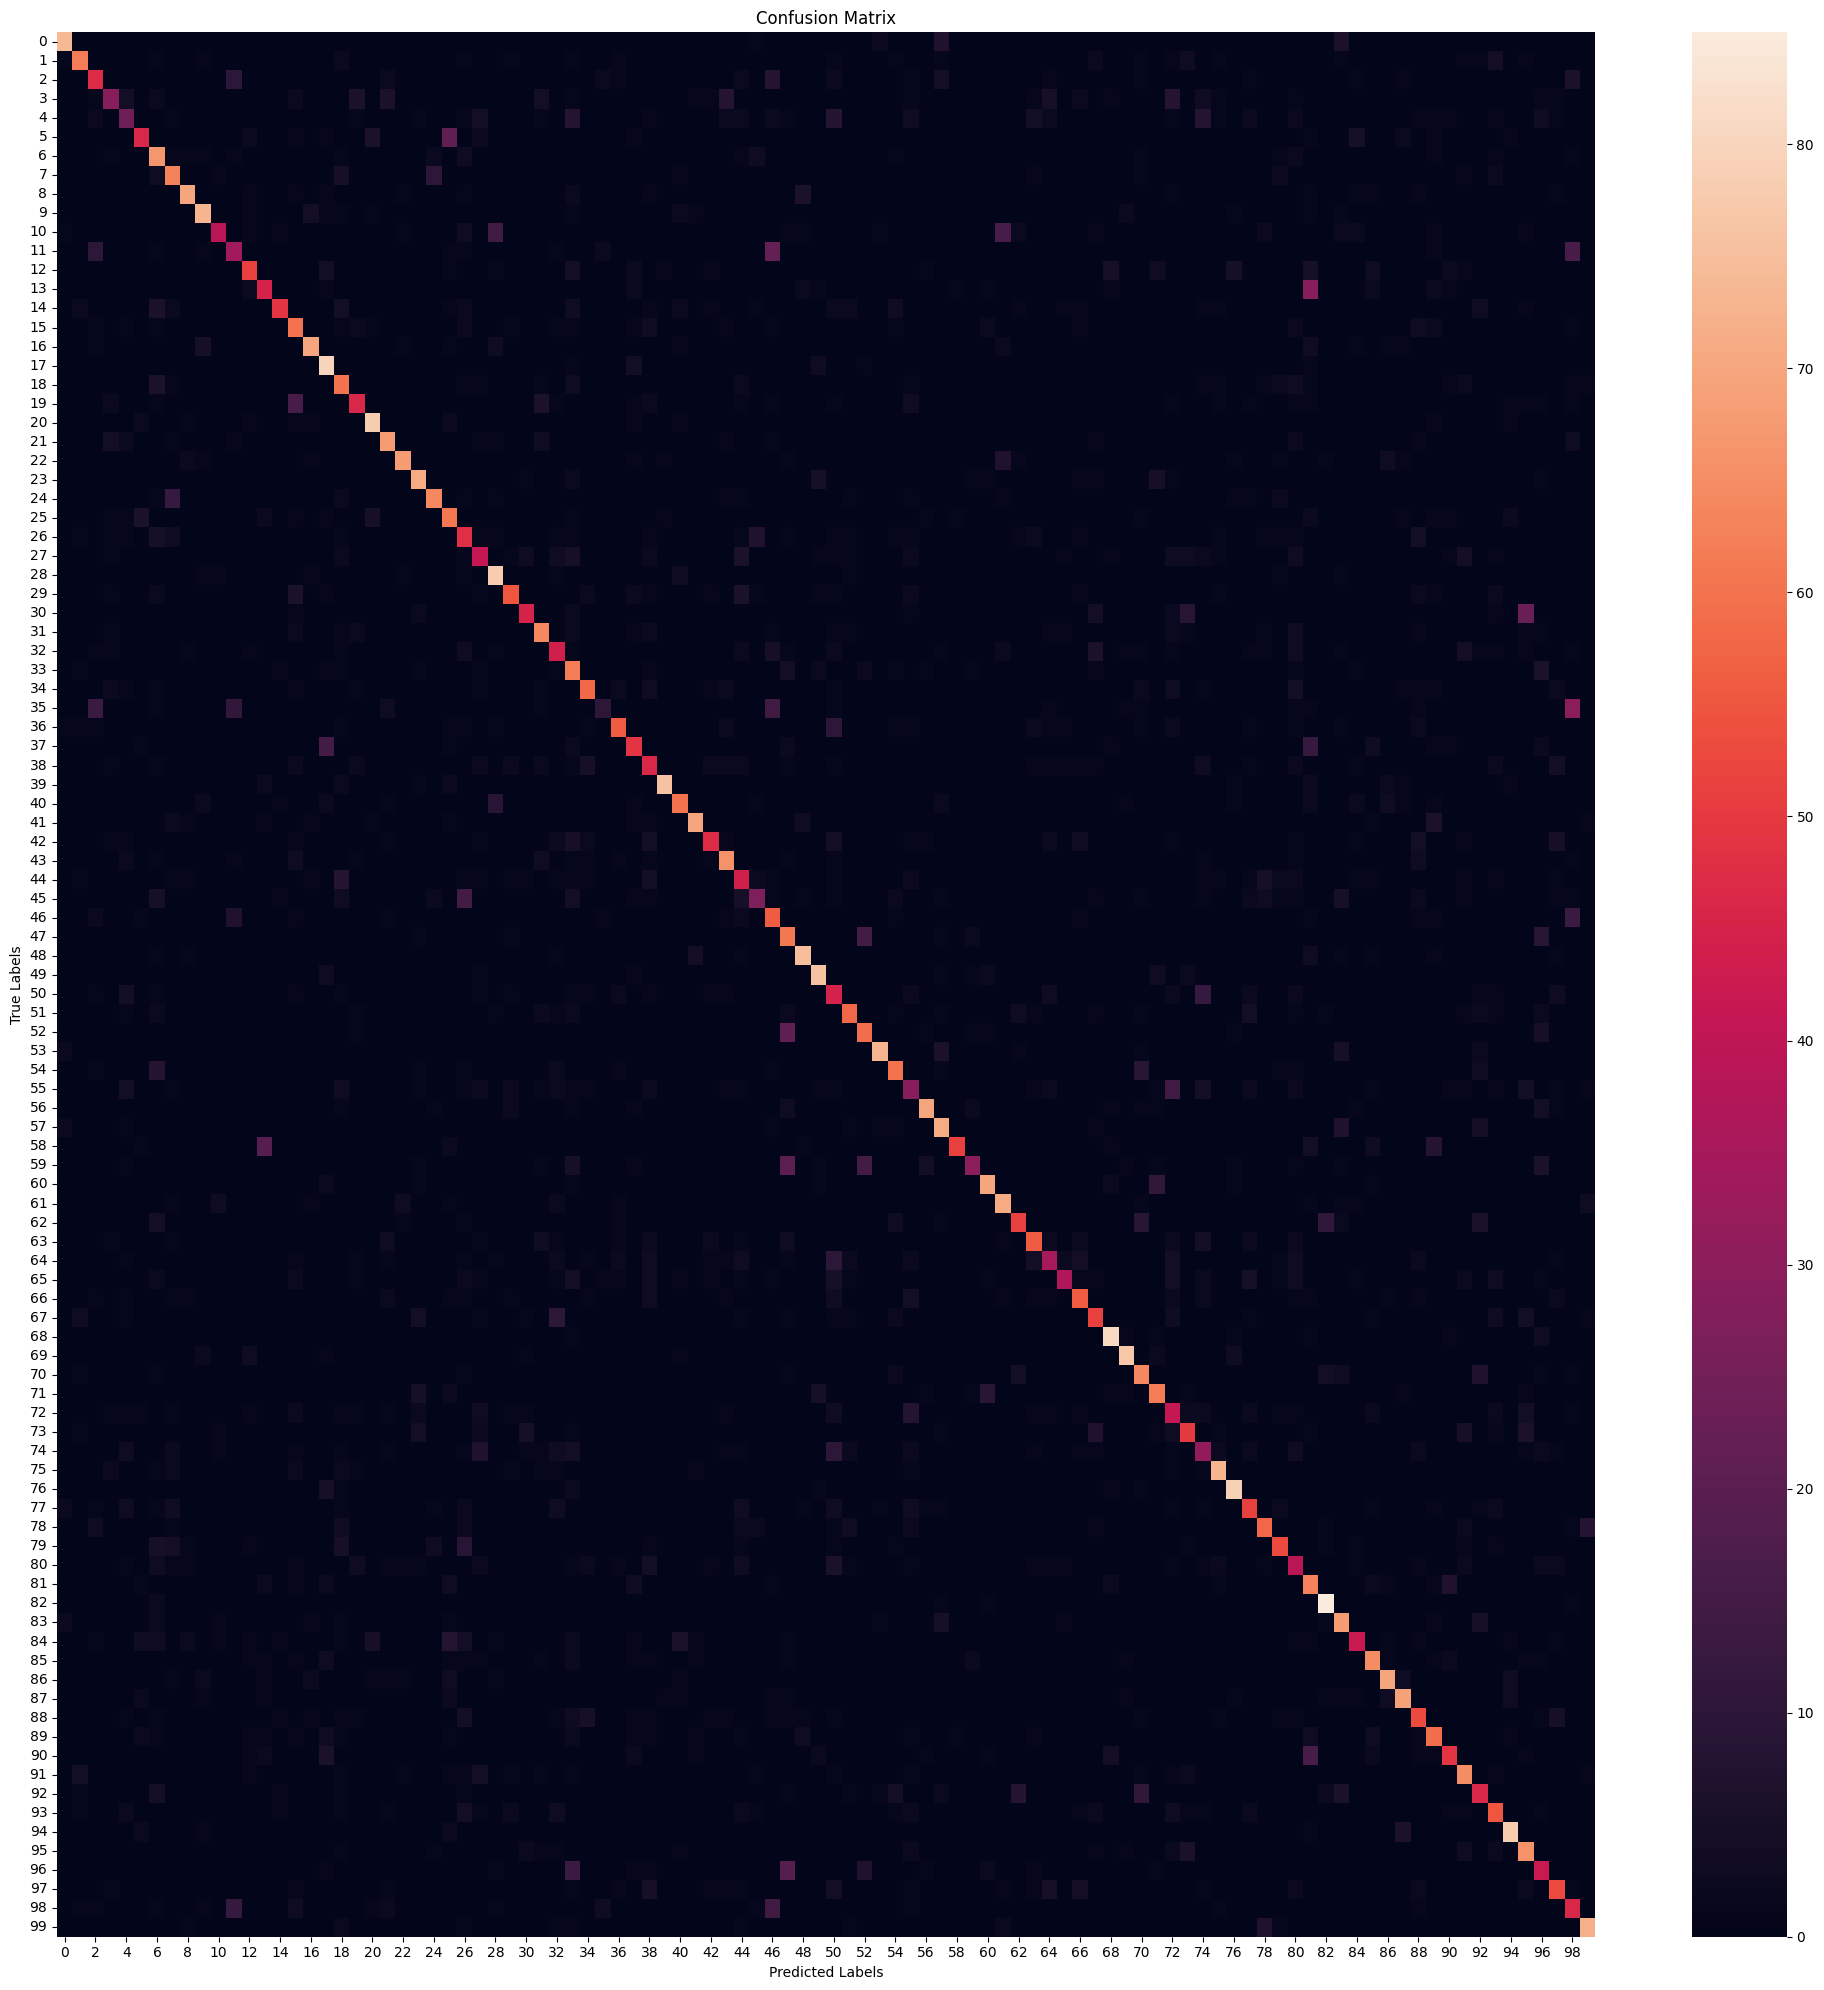

                   precision    recall  f1-score   support

           beaver       0.87      0.82      0.85        90
          dolphin       0.78      0.69      0.73        90
            otter       0.53      0.52      0.53        90
             seal       0.57      0.32      0.41        90
            whale       0.39      0.27      0.32        90
    aquarium fish       0.68      0.51      0.58        90
         flatfish       0.45      0.74      0.56        90
              ray       0.59      0.70      0.64        90
            shark       0.83      0.78      0.80        90
            trout       0.79      0.81      0.80        90
          orchids       0.81      0.43      0.57        90
          poppies       0.44      0.38      0.41        90
            roses       0.73      0.57      0.64        90
       sunflowers       0.58      0.50      0.54        90
           tulips       0.86      0.54      0.67        90
          bottles       0.52      0.67      0.58       

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6086 - f1_score: 0.6059 - loss: 1.3521 - precision: 0.7966
Epoch 1: val_loss improved from inf to 1.24463, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.6087 - f1_score: 0.6059 - loss: 1.3520 - precision: 0.7966 - val_accuracy: 0.6428 - val_f1_score: 0.6406 - val_loss: 1.2446 - val_precision: 0.8284
Epoch 2/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6319 - f1_score: 0.6289 - loss: 1.2525 - precision: 0.8103
Epoch 2: val_loss improved from 1.24463 to 1.23330, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.6319 - f1_score: 0.6289 - loss: 1.2525 - precision: 0.8103 - val_accuracy: 0.6468 - val_f1_score: 0.6446 - val_loss: 1.2333 - val_precision: 0.8268
Epoch 3/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6386 - f1_score: 0.6354 - loss: 1.2321 - precision: 0.8107
Epoch 3: v

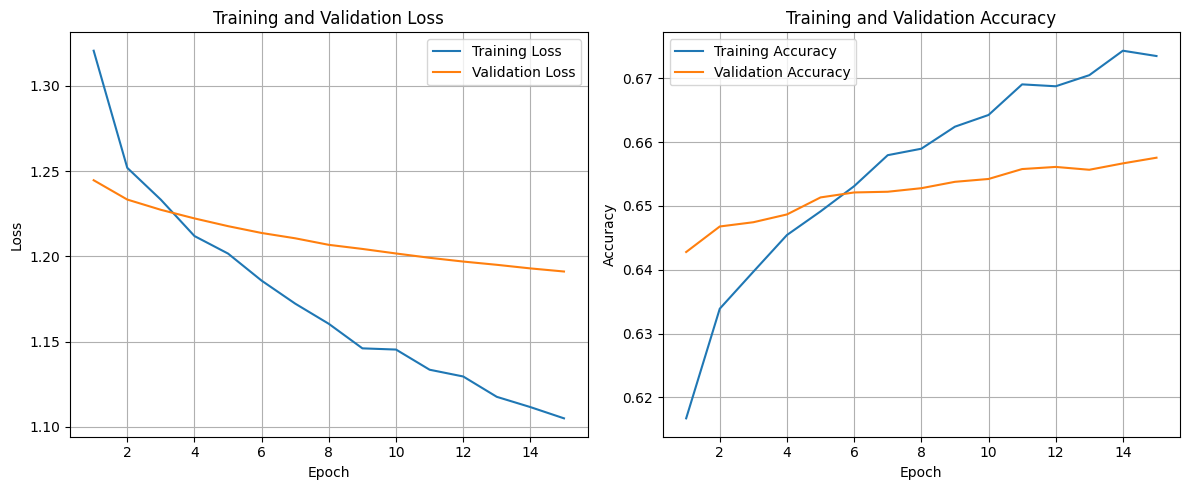

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6515 - f1_score: 0.6438 - loss: 1.2108 - precision: 0.8186
Test Accuracy: 65.88%
Test Loss: 1.1845217943191528
Test Precision: 82.74%
Test F1 Scores (Per Class): [83.798874 77.15736  54.82233  52.694607 37.36263  64.80447  59.595955
 69.36415  79.99999  80.92485  63.73626  53.89221  64.77273  58.959538
 65.88235  61.202175 77.08333  75.89743  58.947365 64.70587  82.16216
 77.24867  78.453026 79.775276 78.68852  68.67469  51.42857  45.999996
 78.65168  71.25     63.5838   69.76743  52.694607 56.852787 68.888885
 35.63218  70.329666 60.63829  51.366108 87.86127  67.36841  85.08286
 64.04494  71.99999  49.46236  43.575413 48.554905 54.878044 81.675385
 82.608696 40.935665 74.86033  64.676605 89.502754 69.38775  36.464085
 79.761894 74.725266 78.82352  59.036137 77.77777  71.8232   67.02702
 65.11627  47.13375  56.97674  59.66851  57.303364 86.02149  83.87096
 70.85714  72.34043  43.428566 61.111103 39.344257 80.64516  88.888885
 58.

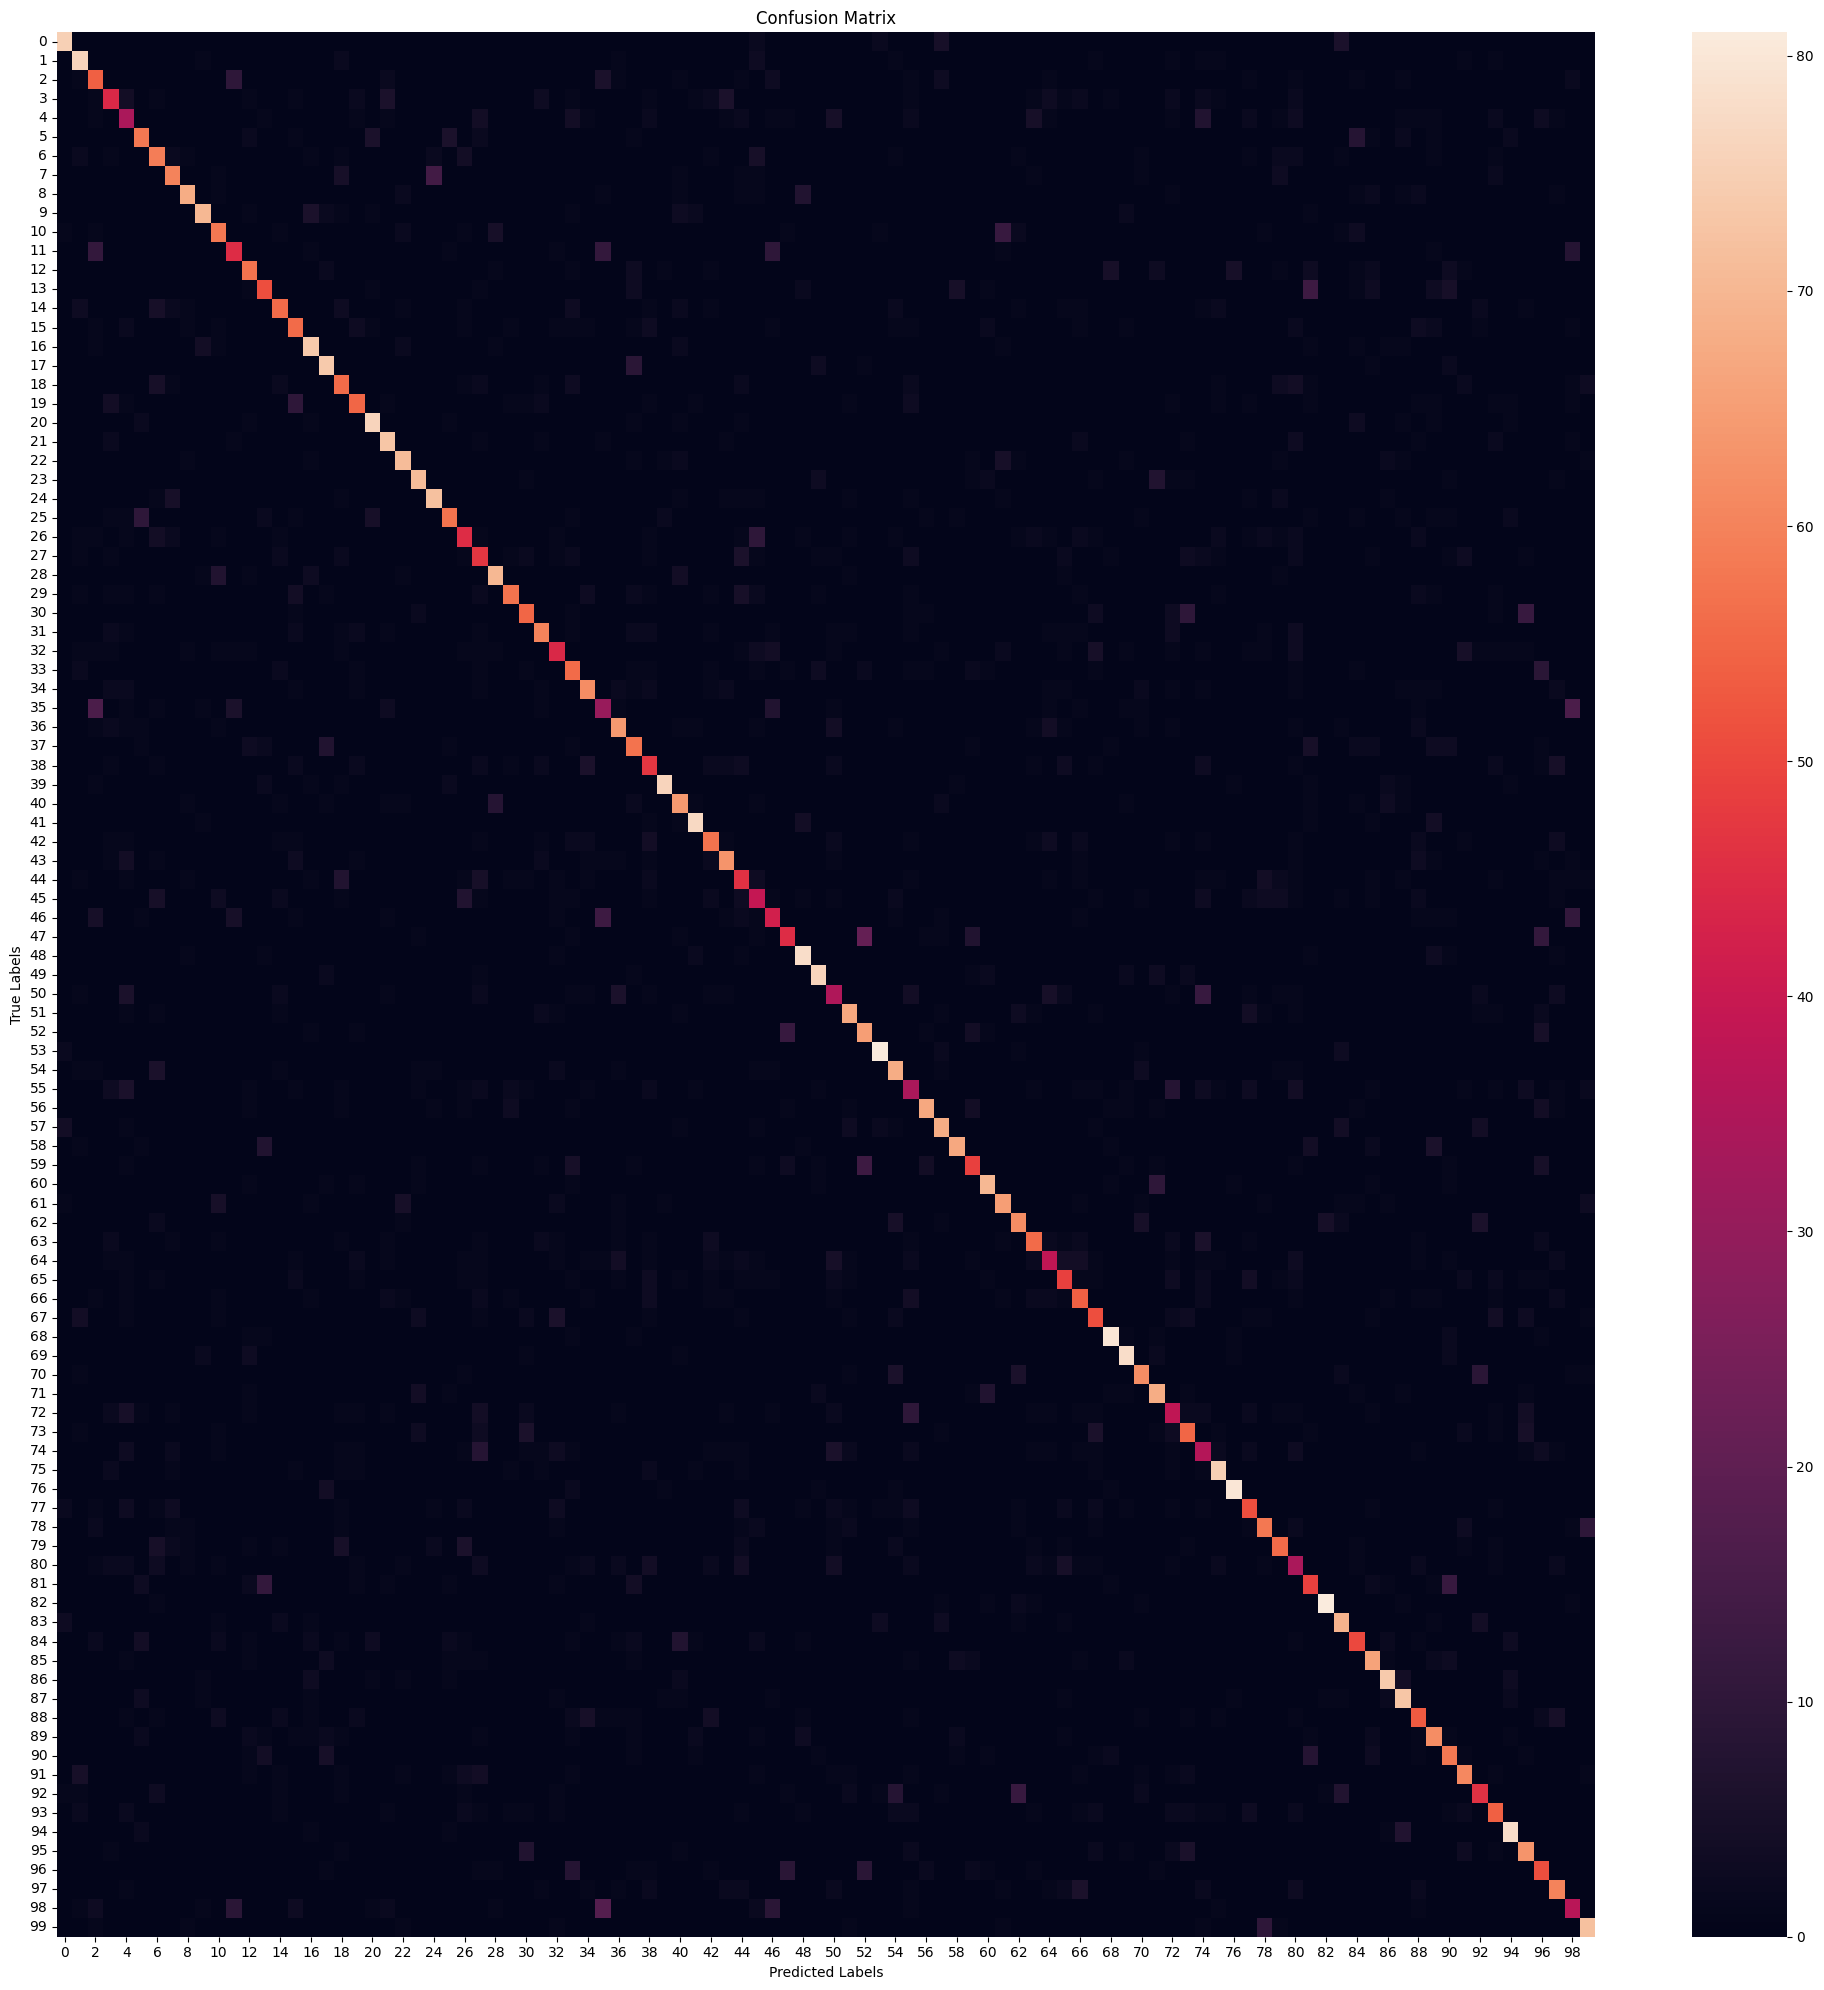

                   precision    recall  f1-score   support

           beaver       0.84      0.83      0.84        90
          dolphin       0.71      0.84      0.77        90
            otter       0.50      0.60      0.55        90
             seal       0.57      0.49      0.53        90
            whale       0.37      0.38      0.37        90
    aquarium fish       0.65      0.64      0.65        90
         flatfish       0.55      0.66      0.60        90
              ray       0.72      0.67      0.69        90
            shark       0.85      0.76      0.80        90
            trout       0.84      0.78      0.81        90
          orchids       0.63      0.64      0.64        90
          poppies       0.58      0.50      0.54        90
            roses       0.66      0.63      0.65        90
       sunflowers       0.61      0.57      0.59        90
           tulips       0.70      0.62      0.66        90
          bottles       0.60      0.62      0.61       

labels[29693].shape: (1,)
imgs[29693].shape: (32, 32, 3)


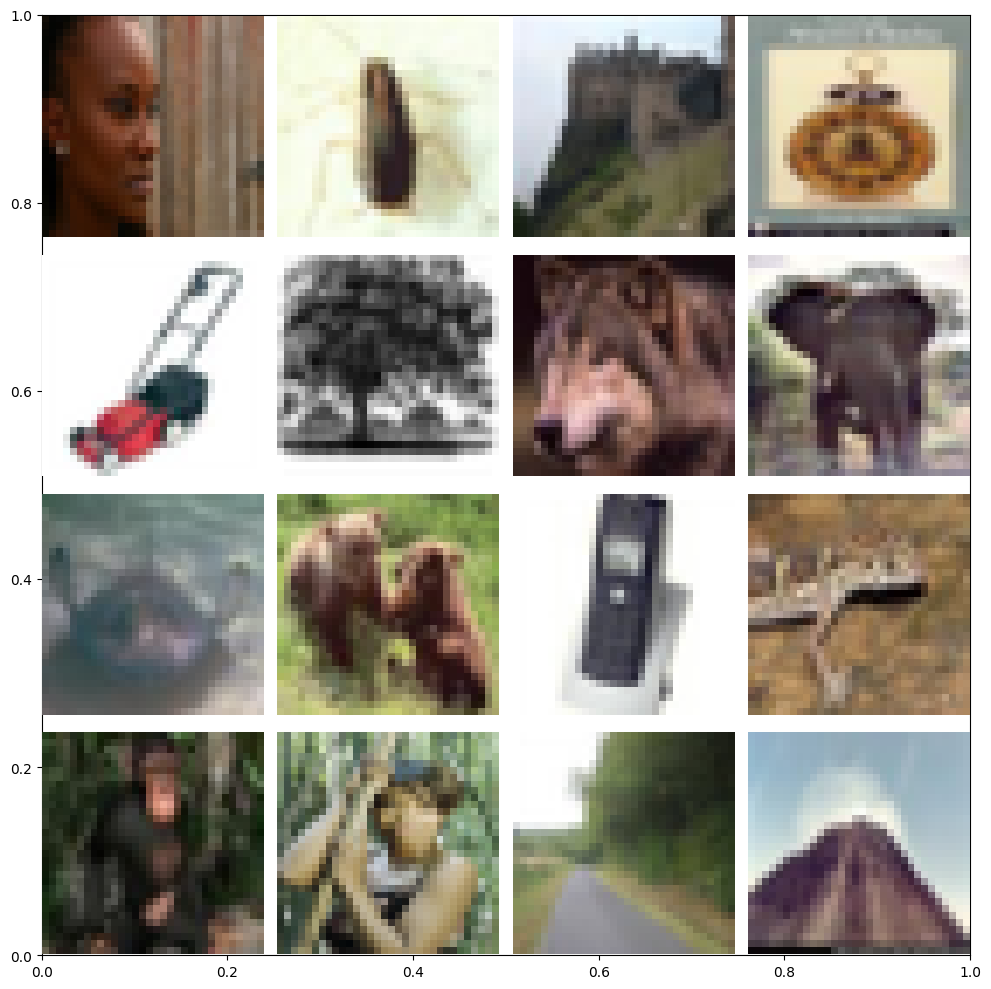

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


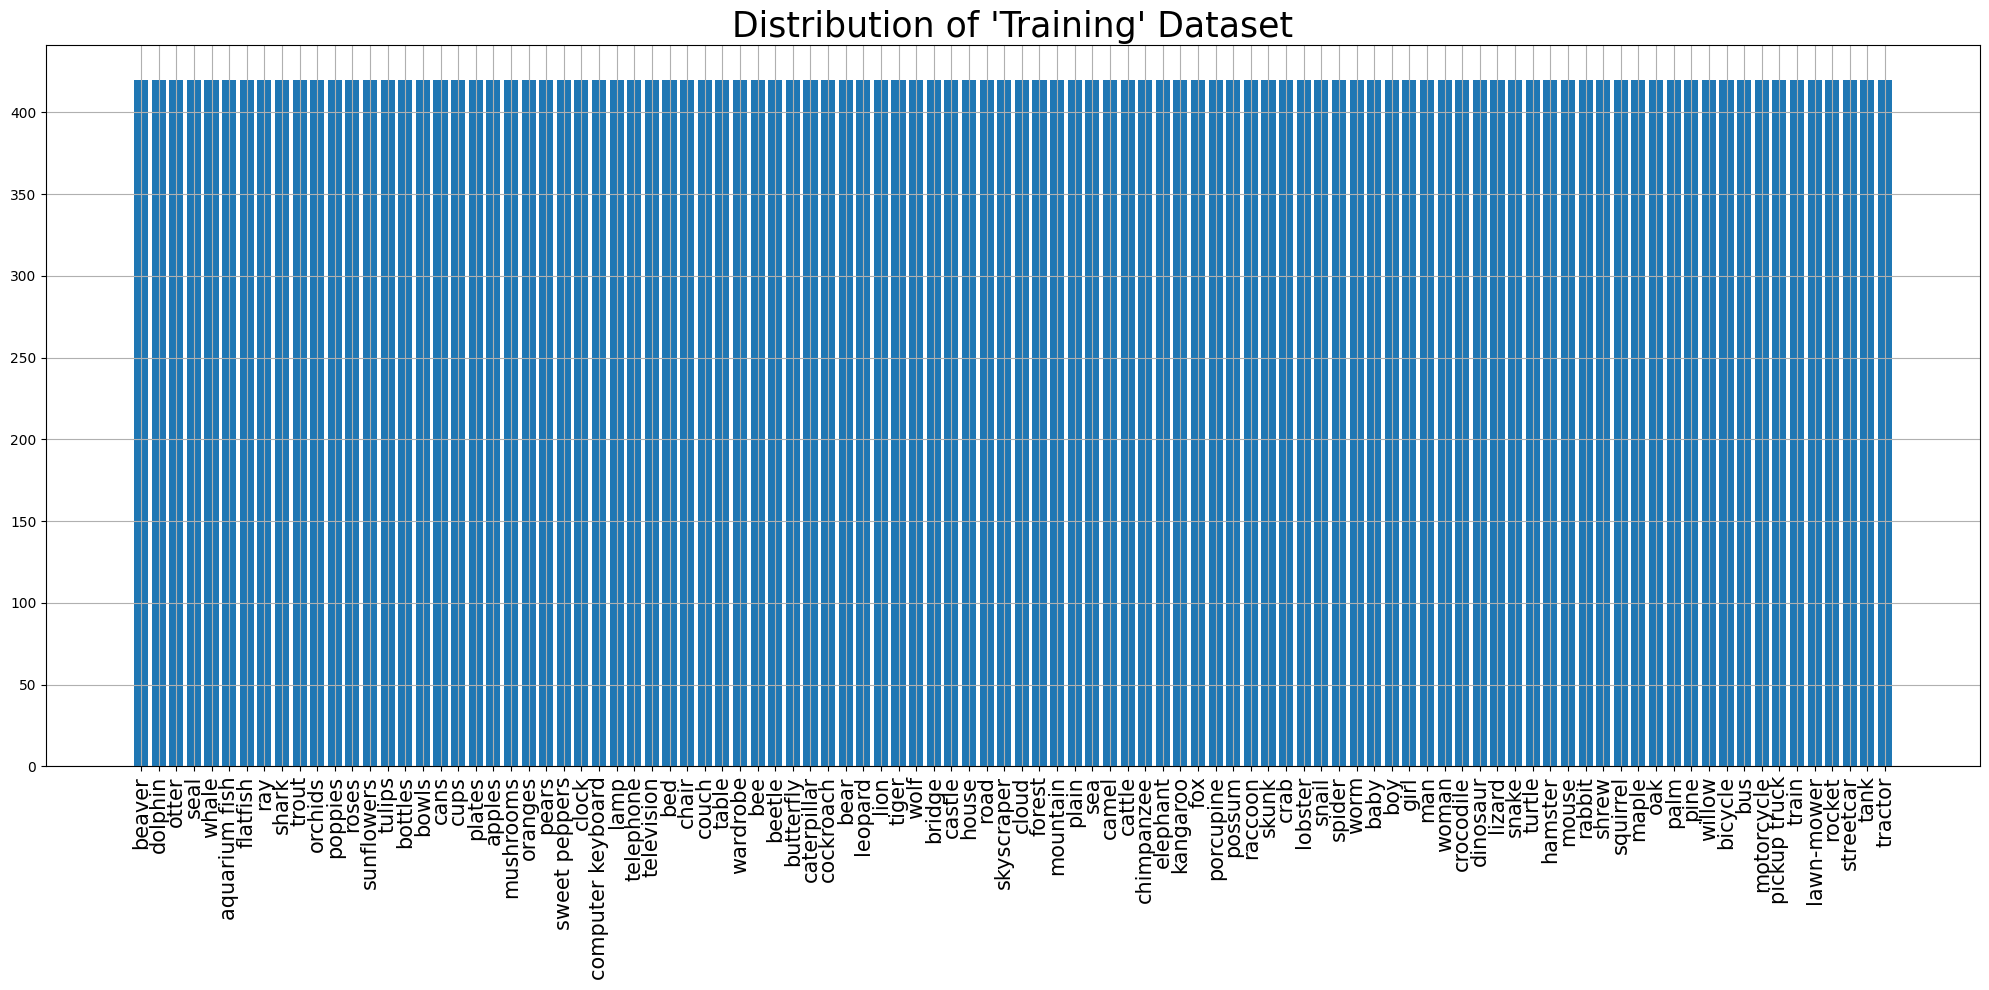

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


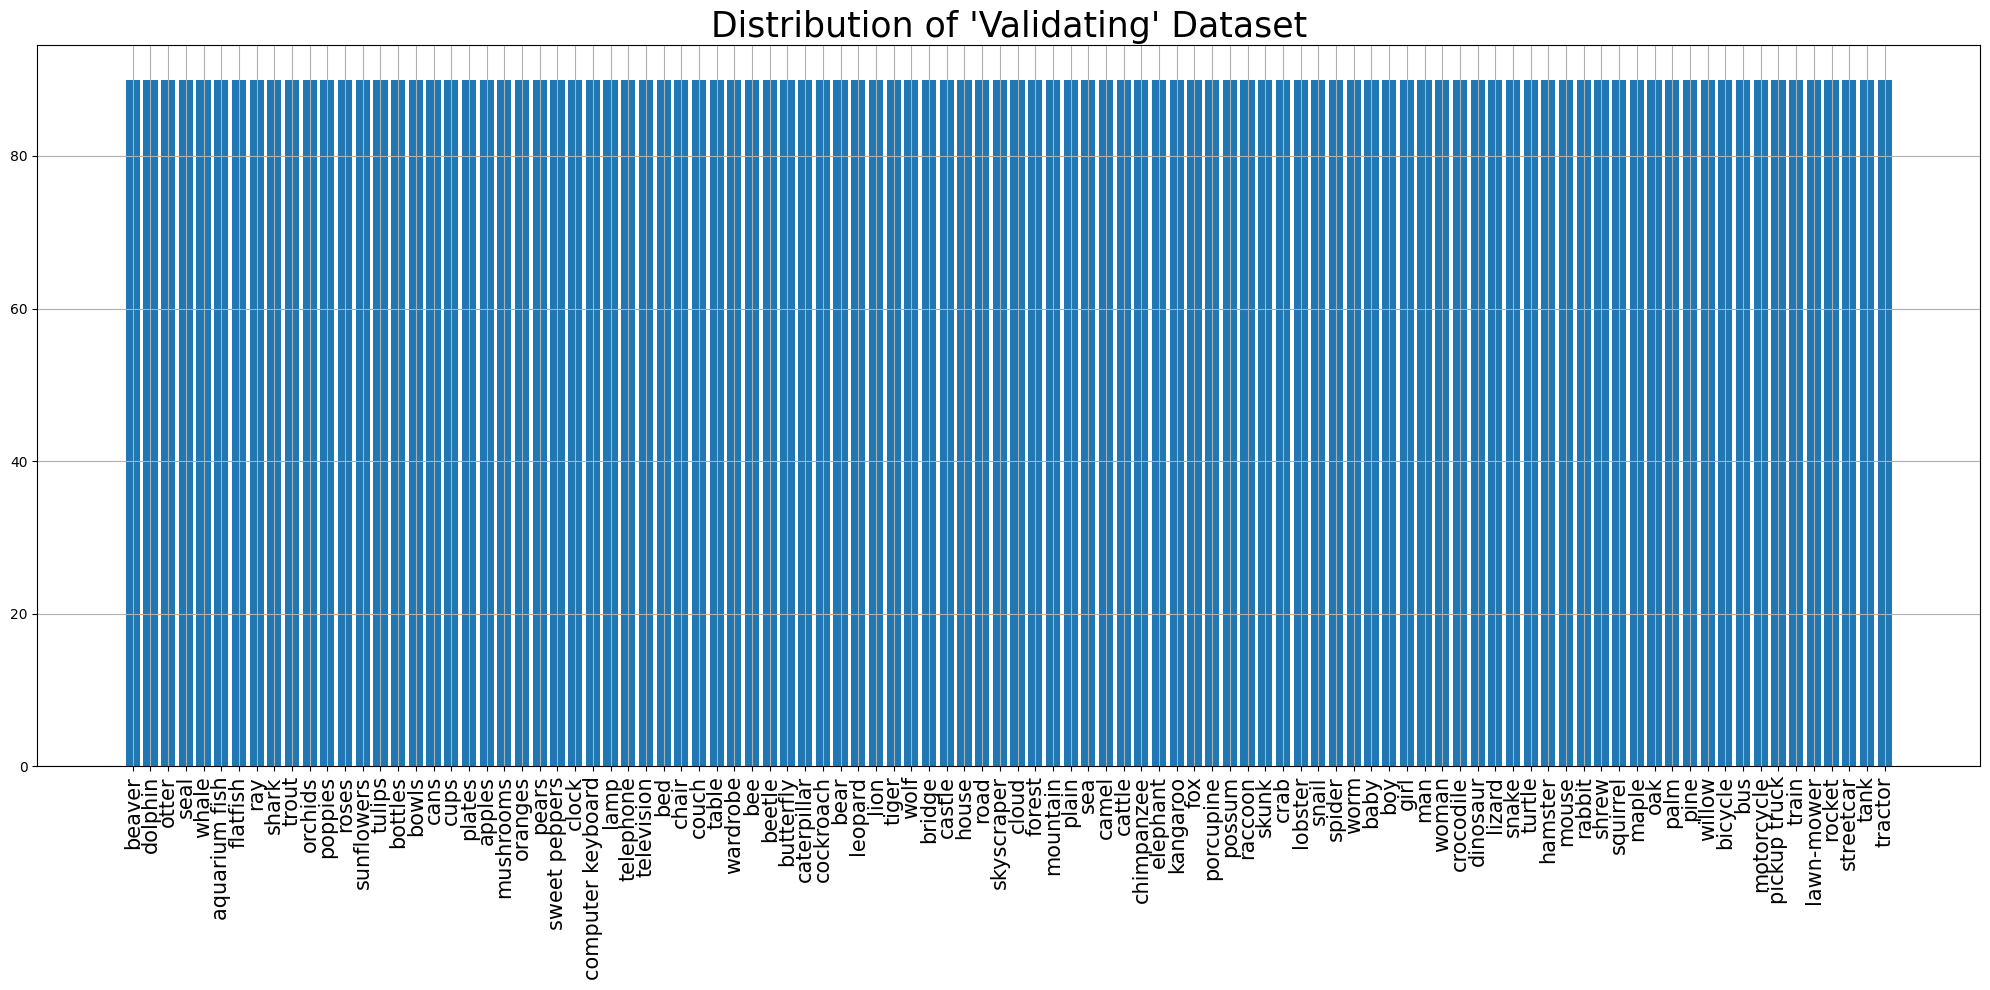

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


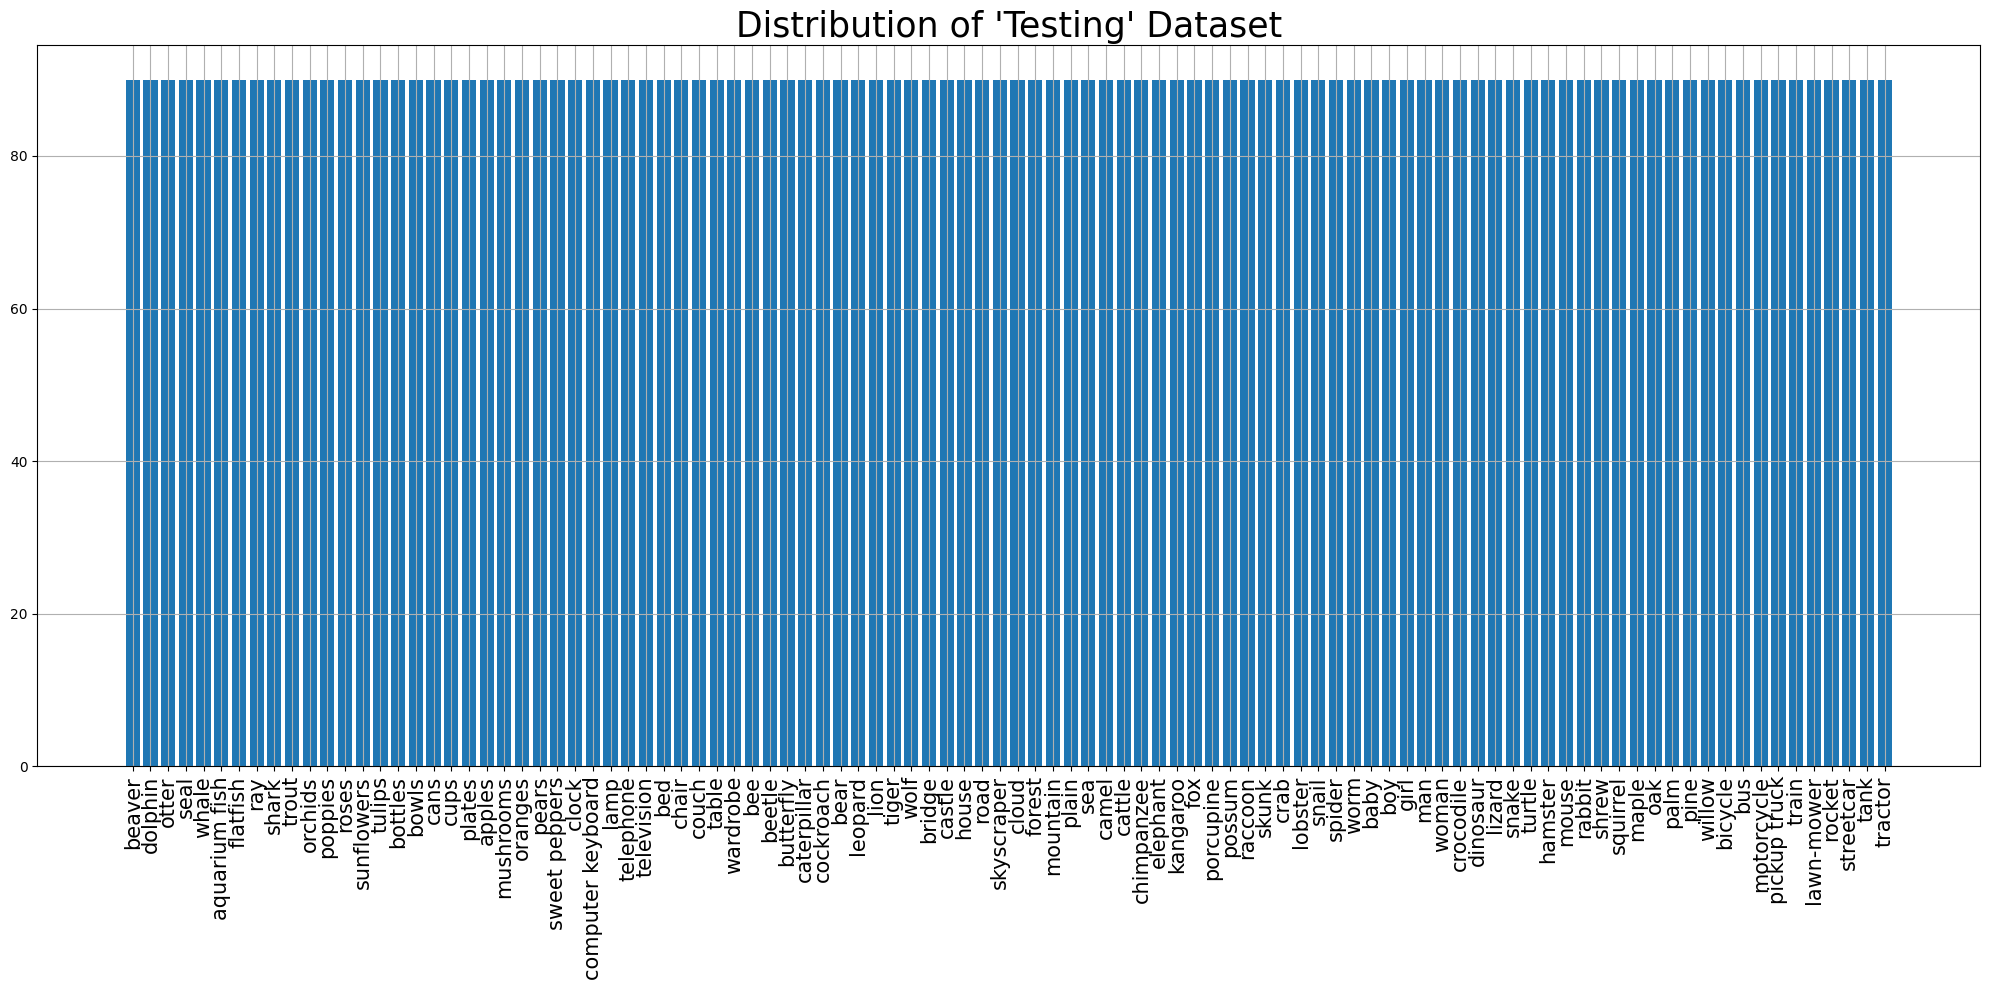

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3) (6

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2630 - f1_score: 0.2559 - loss: 3.1942 - precision: 0.6289
Epoch 1: val_loss improved from inf to 1.58368, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.2631 - f1_score: 0.2561 - loss: 3.1932 - precision: 0.6290 - val_accuracy: 0.5776 - val_f1_score: 0.5698 - val_loss: 1.5837 - val_precision: 0.8350
Epoch 2/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4760 - f1_score: 0.4716 - loss: 1.9423 - precision: 0.7275
Epoch 2: val_loss improved from 1.58368 to 1.47329, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.4760 - f1_score: 0.4716 - loss: 1.9422 - precision: 0.7275 - val_accuracy: 0.5937 - val_f1_score: 0.5899 - val_loss: 1.4733 - val_precision: 0.8270
Epoch 3/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5129 - f1_score: 0.5084 - loss: 1.7747 - precision: 0.7564
Epoch 3: val_loss improved from 1.47329 

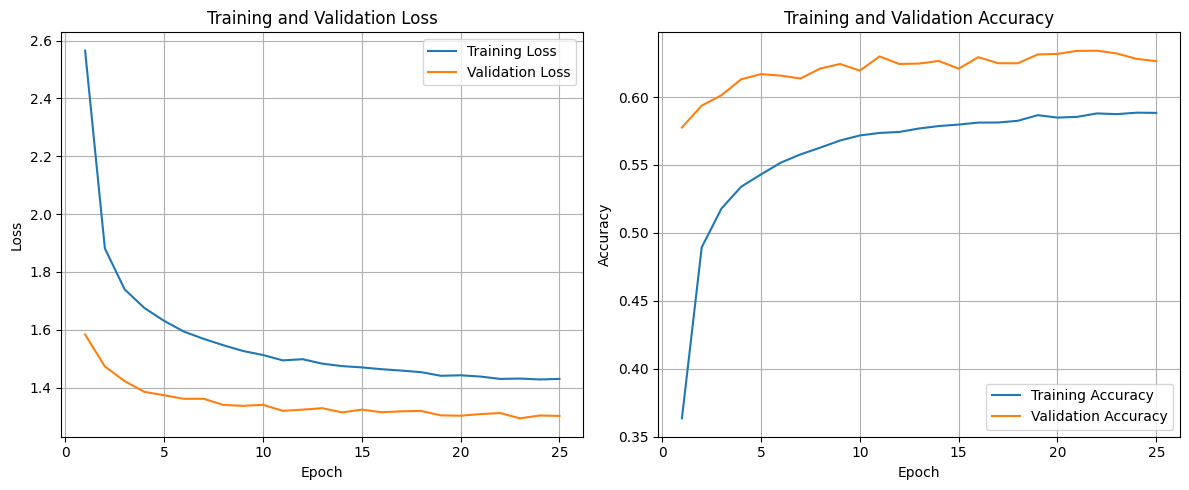

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6235 - f1_score: 0.6165 - loss: 1.3138 - precision: 0.8101
Test Accuracy: 63.33%
Test Loss: 1.285614013671875
Test Precision: 81.69%
Test F1 Scores (Per Class): [84.74575  77.948715 52.68817  50.602406 35.955055 55.345905 58.447487
 66.304344 80.701744 80.       62.820507 45.61403  65.4088   50.7177
 69.23077  56.459324 74.111664 74.881516 54.298634 62.72189  81.21211
 75.97765  77.300606 77.19298  77.09496  59.999996 53.88601  41.142853
 77.34807  66.25767  59.493668 68.57143  43.055553 47.05882  61.46341
 31.343279 66.666664 60.31745  43.786976 88.372086 68.71165  84.74575
 62.025307 69.82249  50.82873  48.05194  44.999996 52.107273 78.75647
 80.92485  45.783127 69.31818  55.13513  86.74699  68.888885 35.36585
 75.82417  67.60563  71.23287  49.999992 79.78141  70.35175  61.797745
 67.02127  44.31137  49.999992 61.87845  59.999992 84.7826   85.057465
 67.85713  75.39267  42.94478  59.685856 34.666664 76.43979  82.7225
 60.20408 

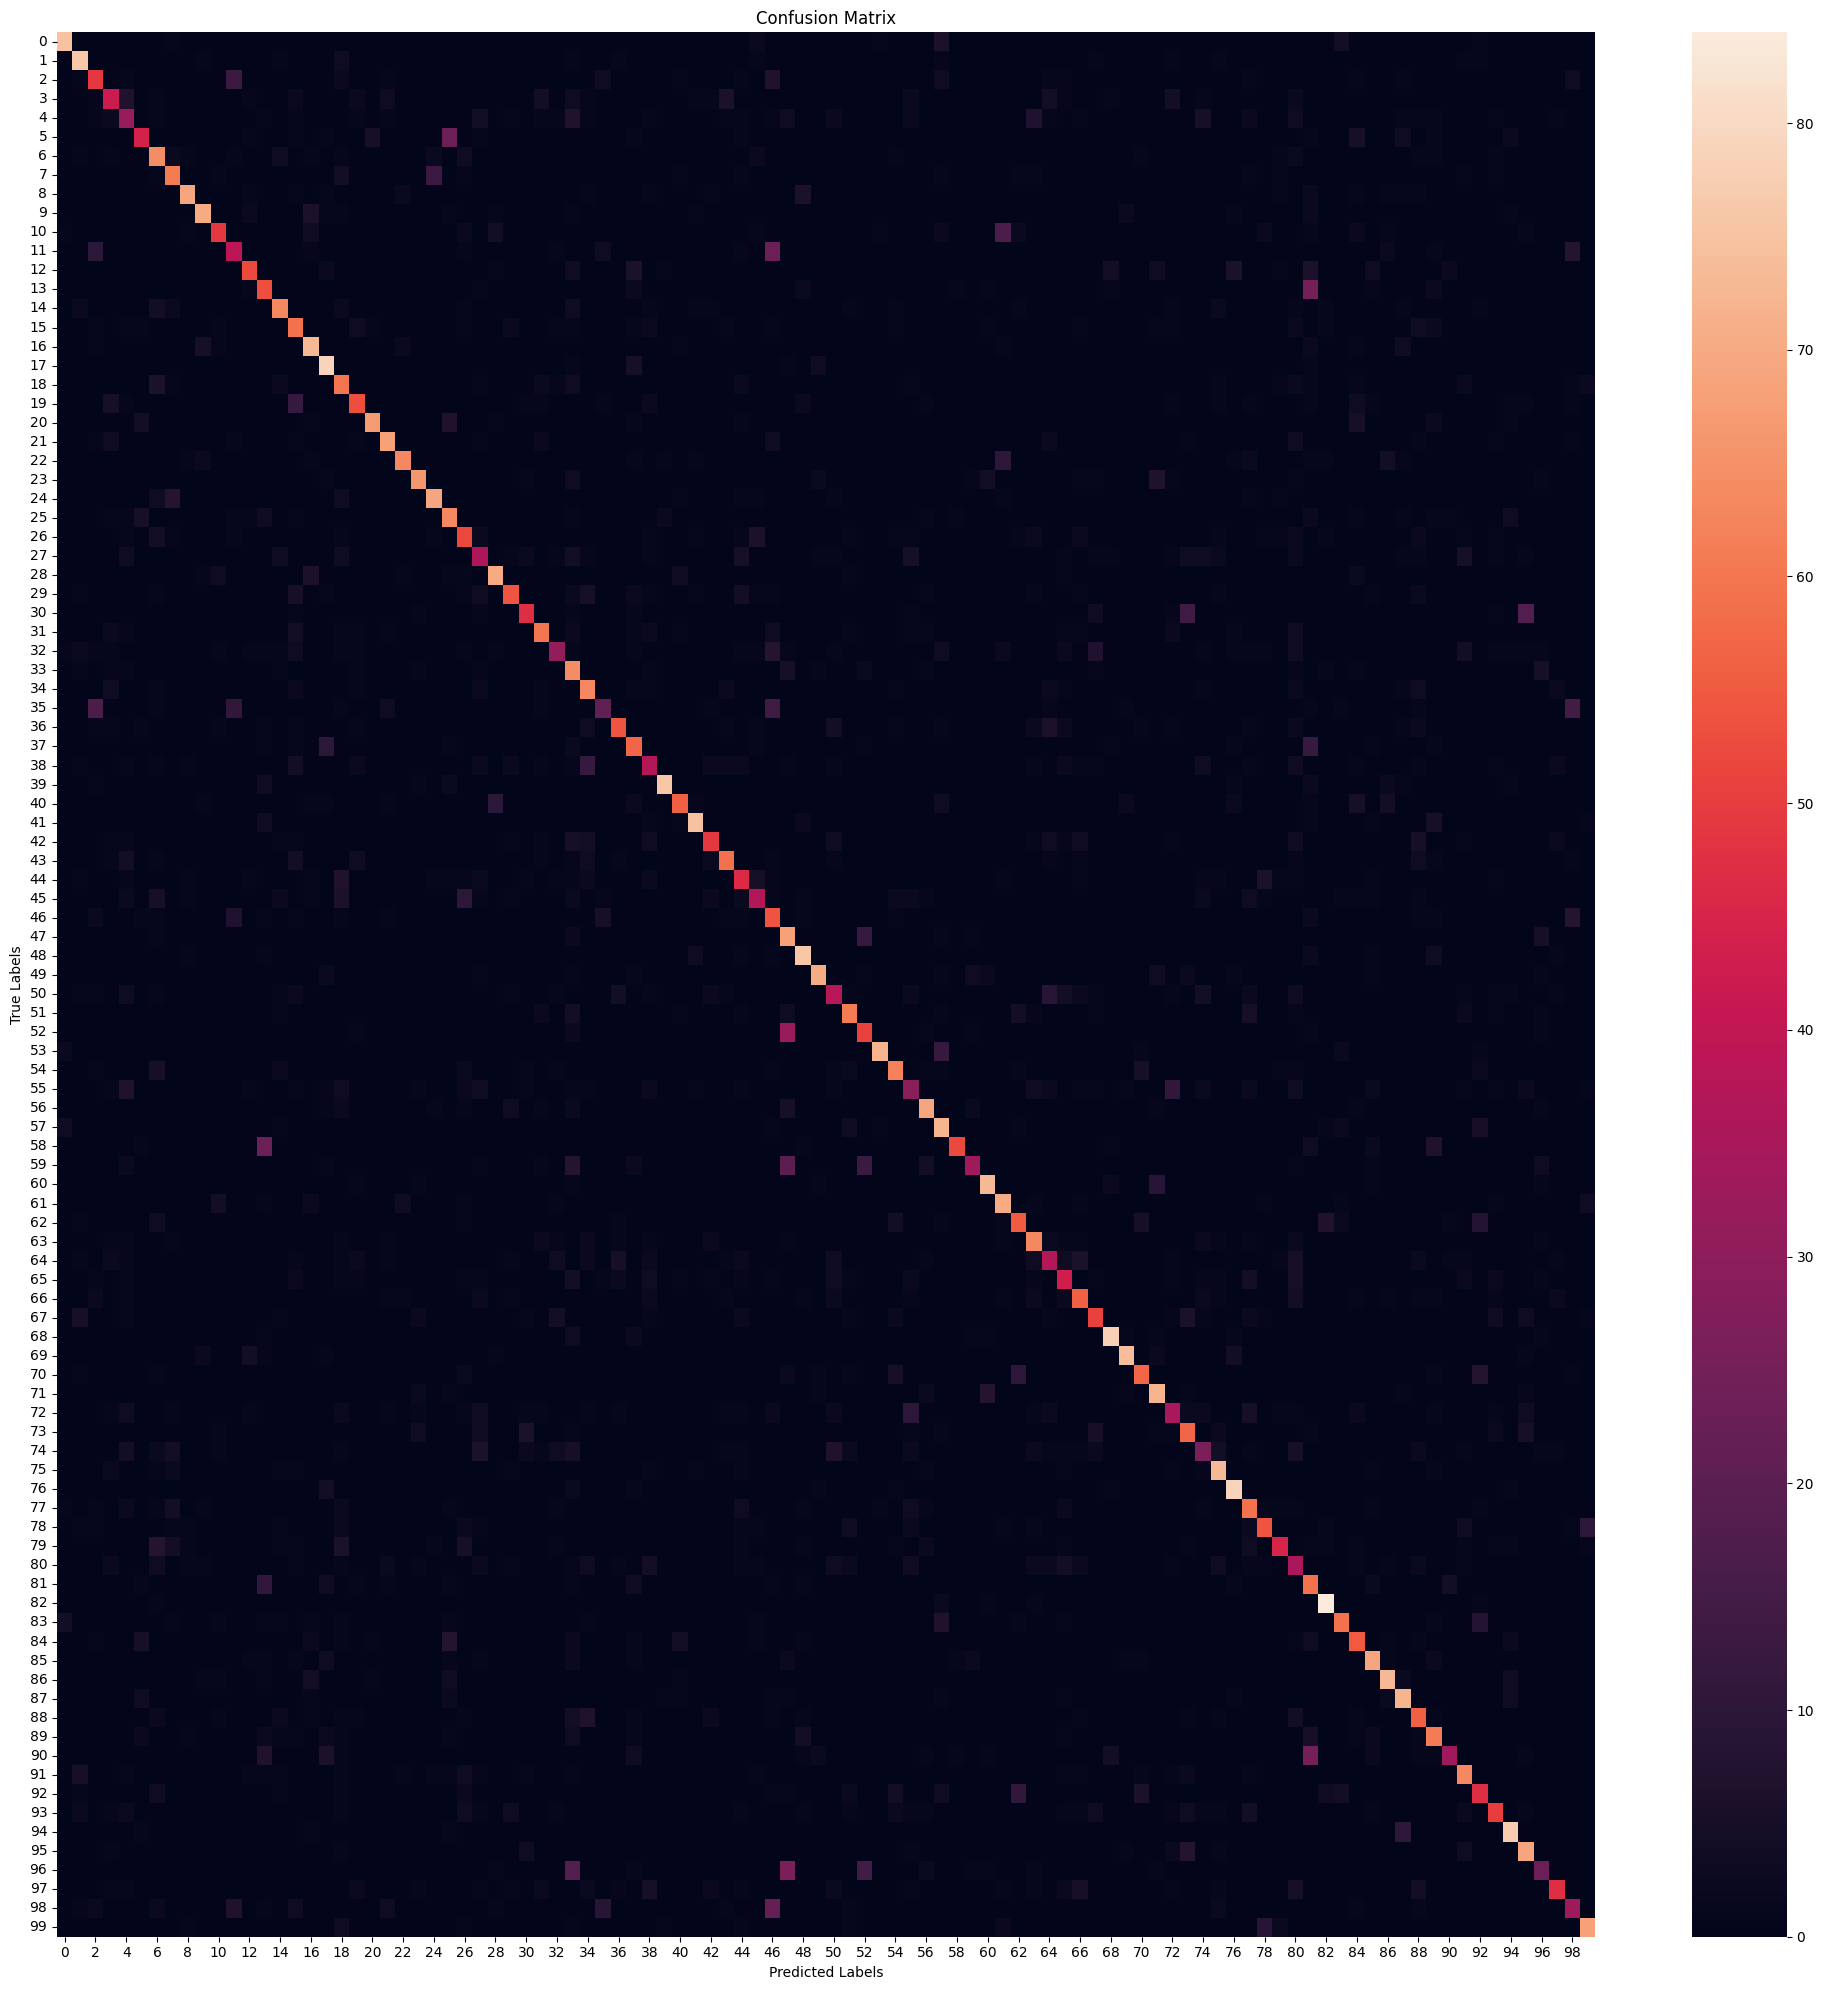

                   precision    recall  f1-score   support

           beaver       0.86      0.83      0.85        90
          dolphin       0.72      0.84      0.78        90
            otter       0.51      0.54      0.53        90
             seal       0.55      0.47      0.51        90
            whale       0.36      0.36      0.36        90
    aquarium fish       0.64      0.49      0.55        90
         flatfish       0.50      0.71      0.58        90
              ray       0.65      0.68      0.66        90
            shark       0.85      0.77      0.81        90
            trout       0.82      0.78      0.80        90
          orchids       0.74      0.54      0.63        90
          poppies       0.48      0.43      0.46        90
            roses       0.75      0.58      0.65        90
       sunflowers       0.45      0.59      0.51        90
           tulips       0.68      0.70      0.69        90
          bottles       0.50      0.66      0.56       

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6028 - f1_score: 0.5997 - loss: 1.3624 - precision: 0.7873
Epoch 1: val_loss improved from inf to 1.24024, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.6028 - f1_score: 0.5997 - loss: 1.3623 - precision: 0.7873 - val_accuracy: 0.6501 - val_f1_score: 0.6480 - val_loss: 1.2402 - val_precision: 0.8298
Epoch 2/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6289 - f1_score: 0.6259 - loss: 1.2675 - precision: 0.8066
Epoch 2: val_loss improved from 1.24024 to 1.23065, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.6289 - f1_score: 0.6259 - loss: 1.2675 - precision: 0.8066 - val_accuracy: 0.6514 - val_f1_score: 0.6494 - val_loss: 1.2307 - val_precision: 0.8283
Epoch 3/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6362 - f1_score: 0.6333 - loss: 1.2384 - precision: 0.8109
Epoch 3: v

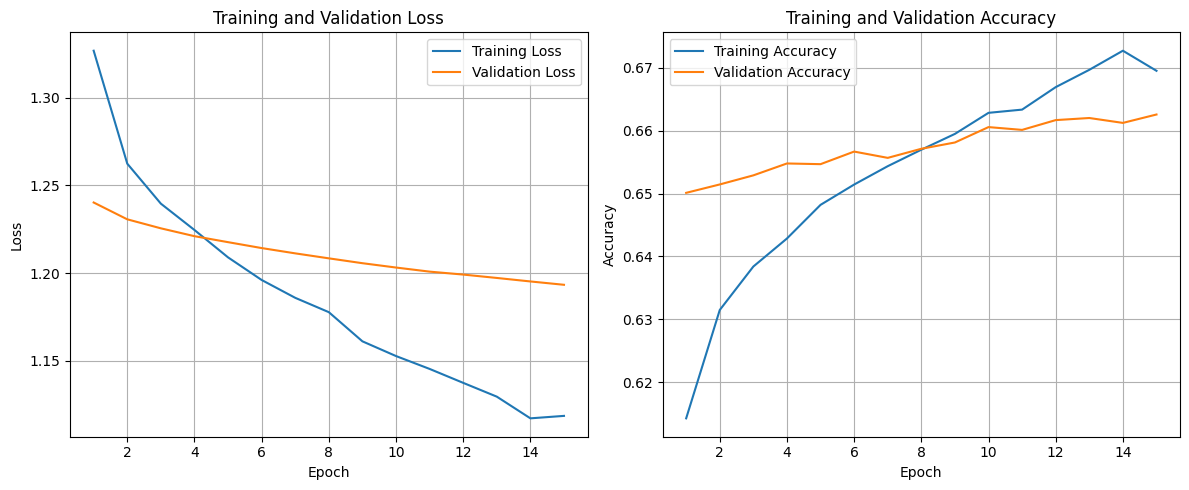

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.6536 - f1_score: 0.6457 - loss: 1.2064 - precision: 0.8177
Test Accuracy: 66.27%
Test Loss: 1.181408166885376
Test Precision: 82.71%
Test F1 Scores (Per Class): [85.39326  78.07486  54.639168 51.136356 38.20224  67.02702  58.883244
 71.67629  82.352936 80.22598  67.415726 48.48484  67.816086 59.550552
 65.49707  62.569828 77.7202   76.923065 62.365585 65.11627  79.347824
 79.365074 80.43478  78.88888  83.060104 66.26506  55.49132  46.29629
 77.9661   65.060234 63.636356 69.82249  53.89221  57.843132 67.3913
 30.58823  68.852455 61.538452 51.933693 87.86127  69.23077  85.8757
 64.04494  73.863625 51.06383  46.408836 51.42857  57.66871  80.628265
 82.872925 43.137253 71.67629  66.99028  91.01122  70.243904 38.461533
 82.558136 72.625694 79.04191  55.421684 80.21977  72.72727  64.51612
 65.14285  46.249996 54.945045 61.363636 61.714287 86.33879  84.946236
 72.41379  75.64766  42.682922 62.032085 36.956516 81.28342  85.405396
 56.976

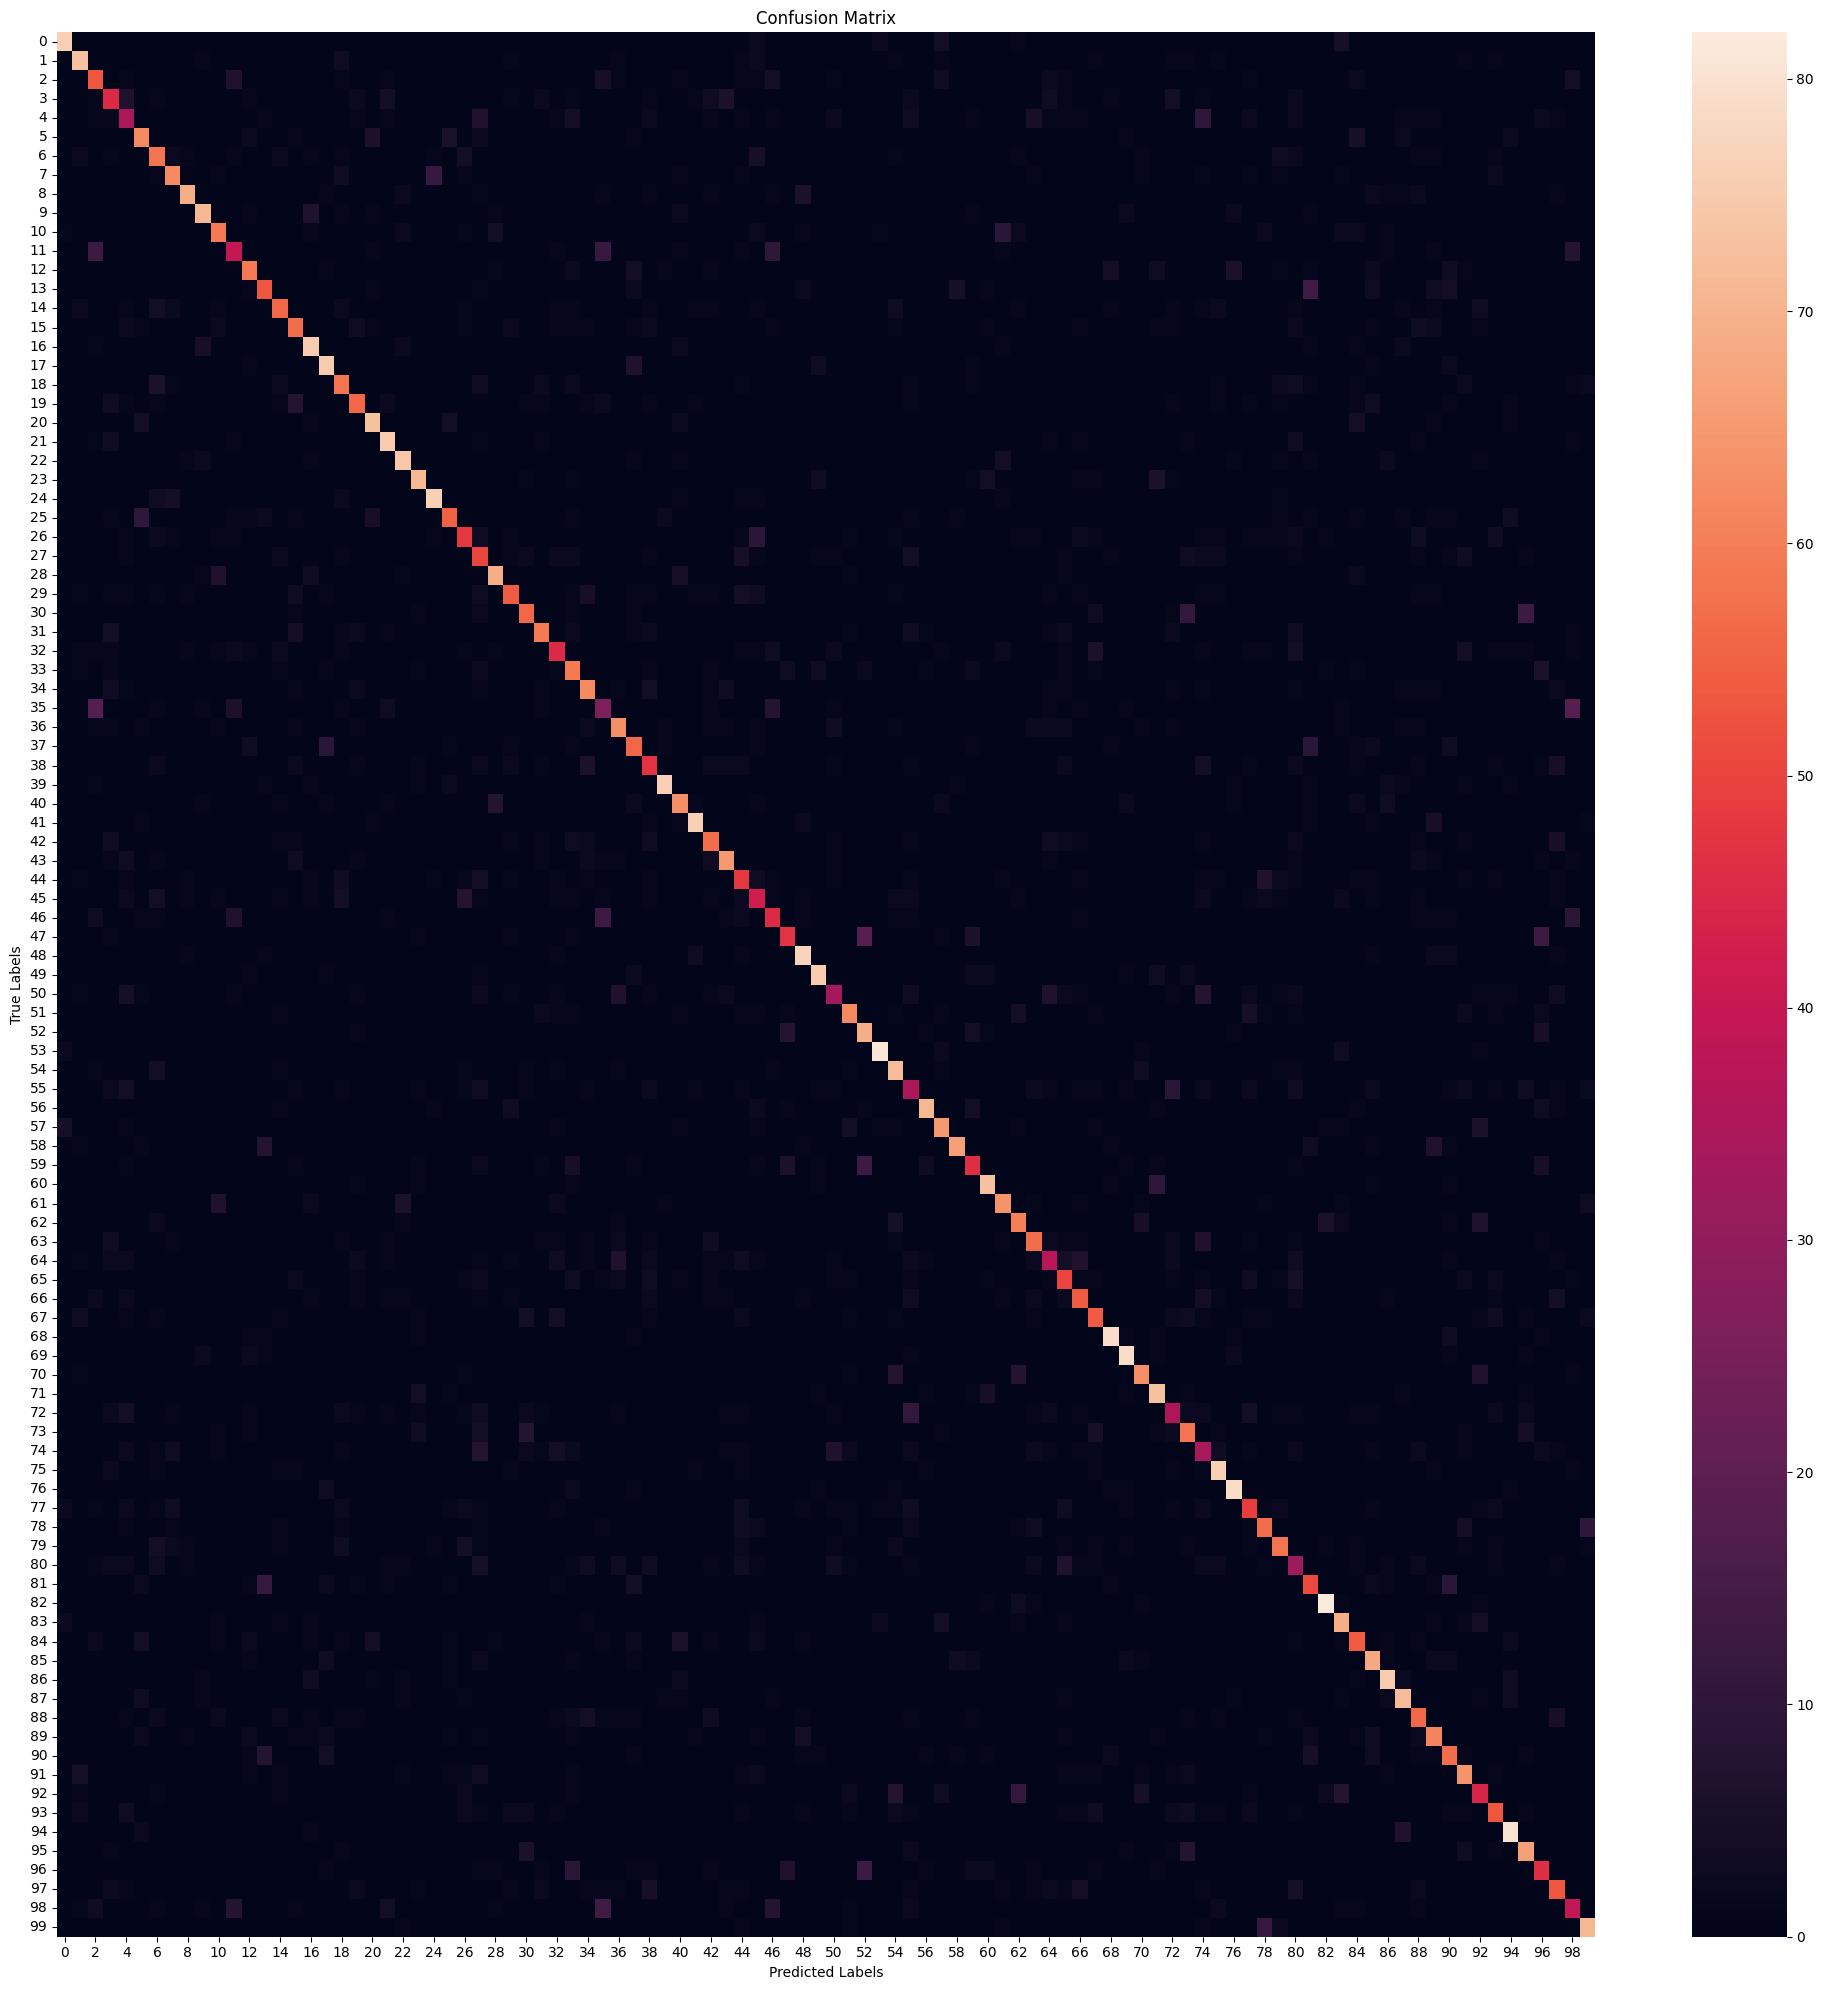

                   precision    recall  f1-score   support

           beaver       0.86      0.84      0.85        90
          dolphin       0.75      0.81      0.78        90
            otter       0.51      0.59      0.55        90
             seal       0.52      0.50      0.51        90
            whale       0.39      0.38      0.38        90
    aquarium fish       0.65      0.69      0.67        90
         flatfish       0.54      0.64      0.59        90
              ray       0.75      0.69      0.72        90
            shark       0.87      0.77      0.82        90
            trout       0.82      0.79      0.80        90
          orchids       0.68      0.66      0.67        90
          poppies       0.53      0.44      0.48        90
            roses       0.70      0.66      0.68        90
       sunflowers       0.60      0.59      0.60        90
           tulips       0.69      0.62      0.65        90
          bottles       0.63      0.63      0.63       

In [5]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64

    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    #train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
    #                 .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #                 .batch(batch_size)
    #                 .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_#.concatenate(train_dataset_aug)

    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(3e-1) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.7), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-1), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model_v2.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune_v2.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model_v2.keras')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune_v2.keras')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist

# Dropout(0.7), L2Reg(3e-1), weight_decay(3e-2), train_augmentation

X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[28620].shape: (1,)
imgs[28620].shape: (32, 32, 3)


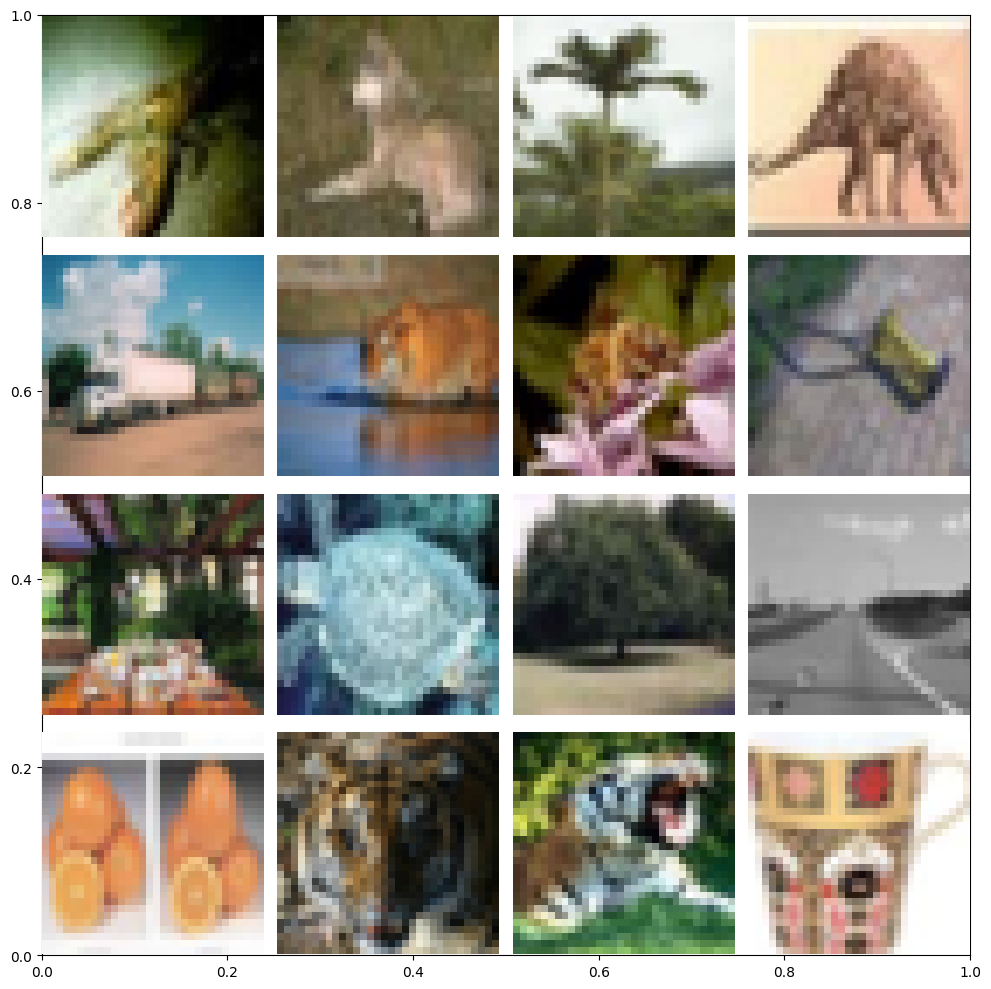

labels[28896].shape: (1,)
imgs[28896].shape: (32, 32, 3)


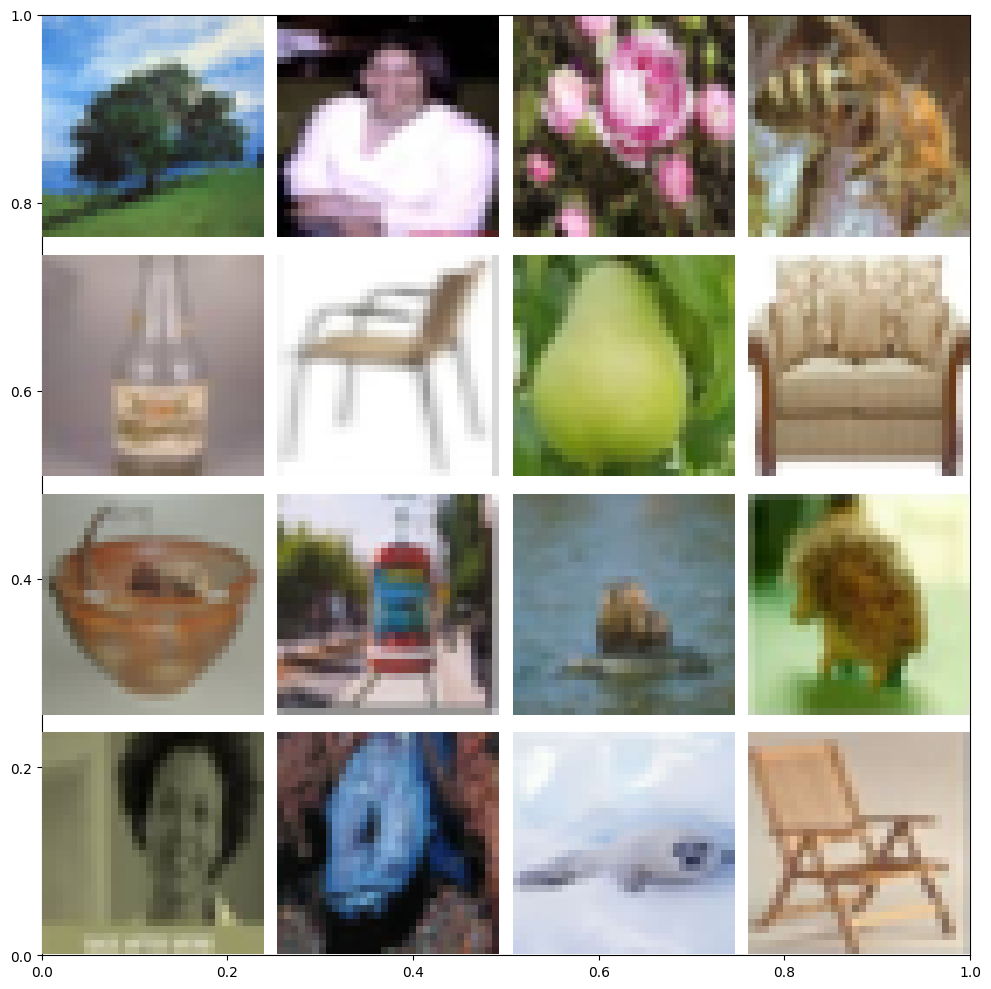

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


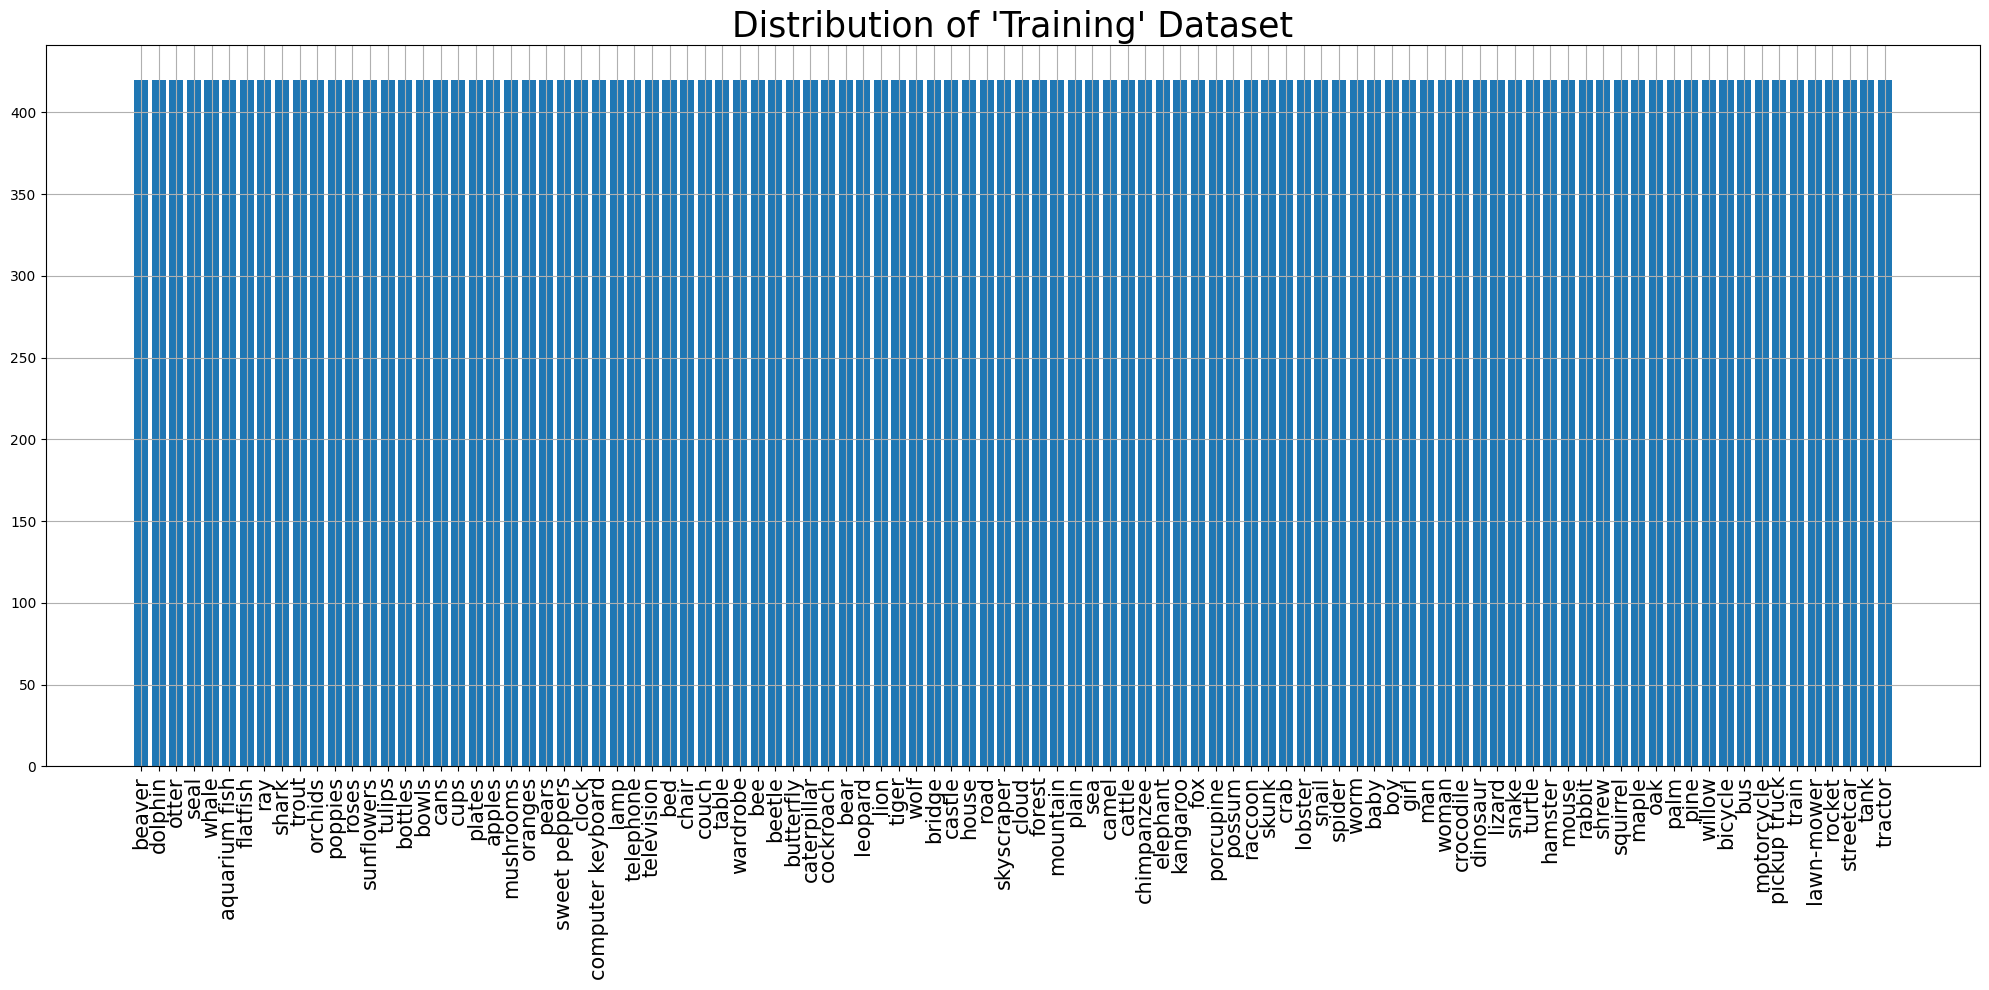

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


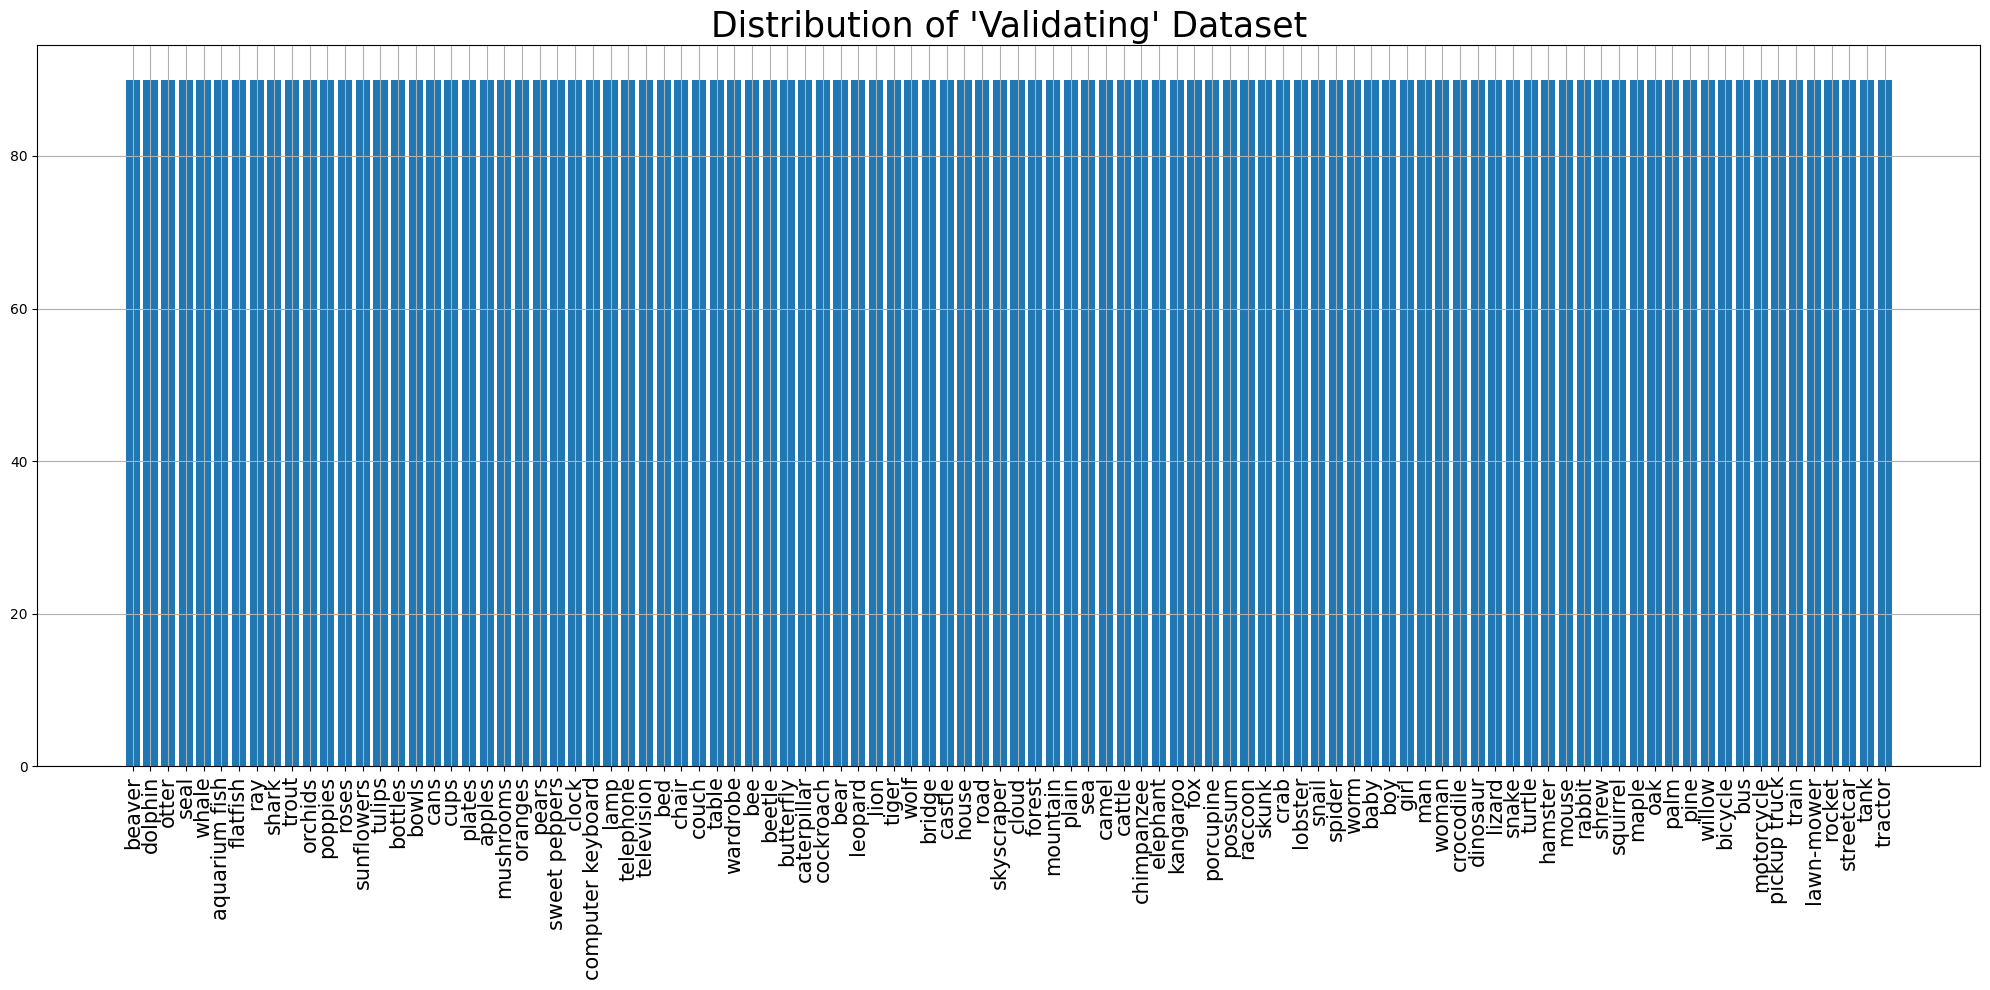

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


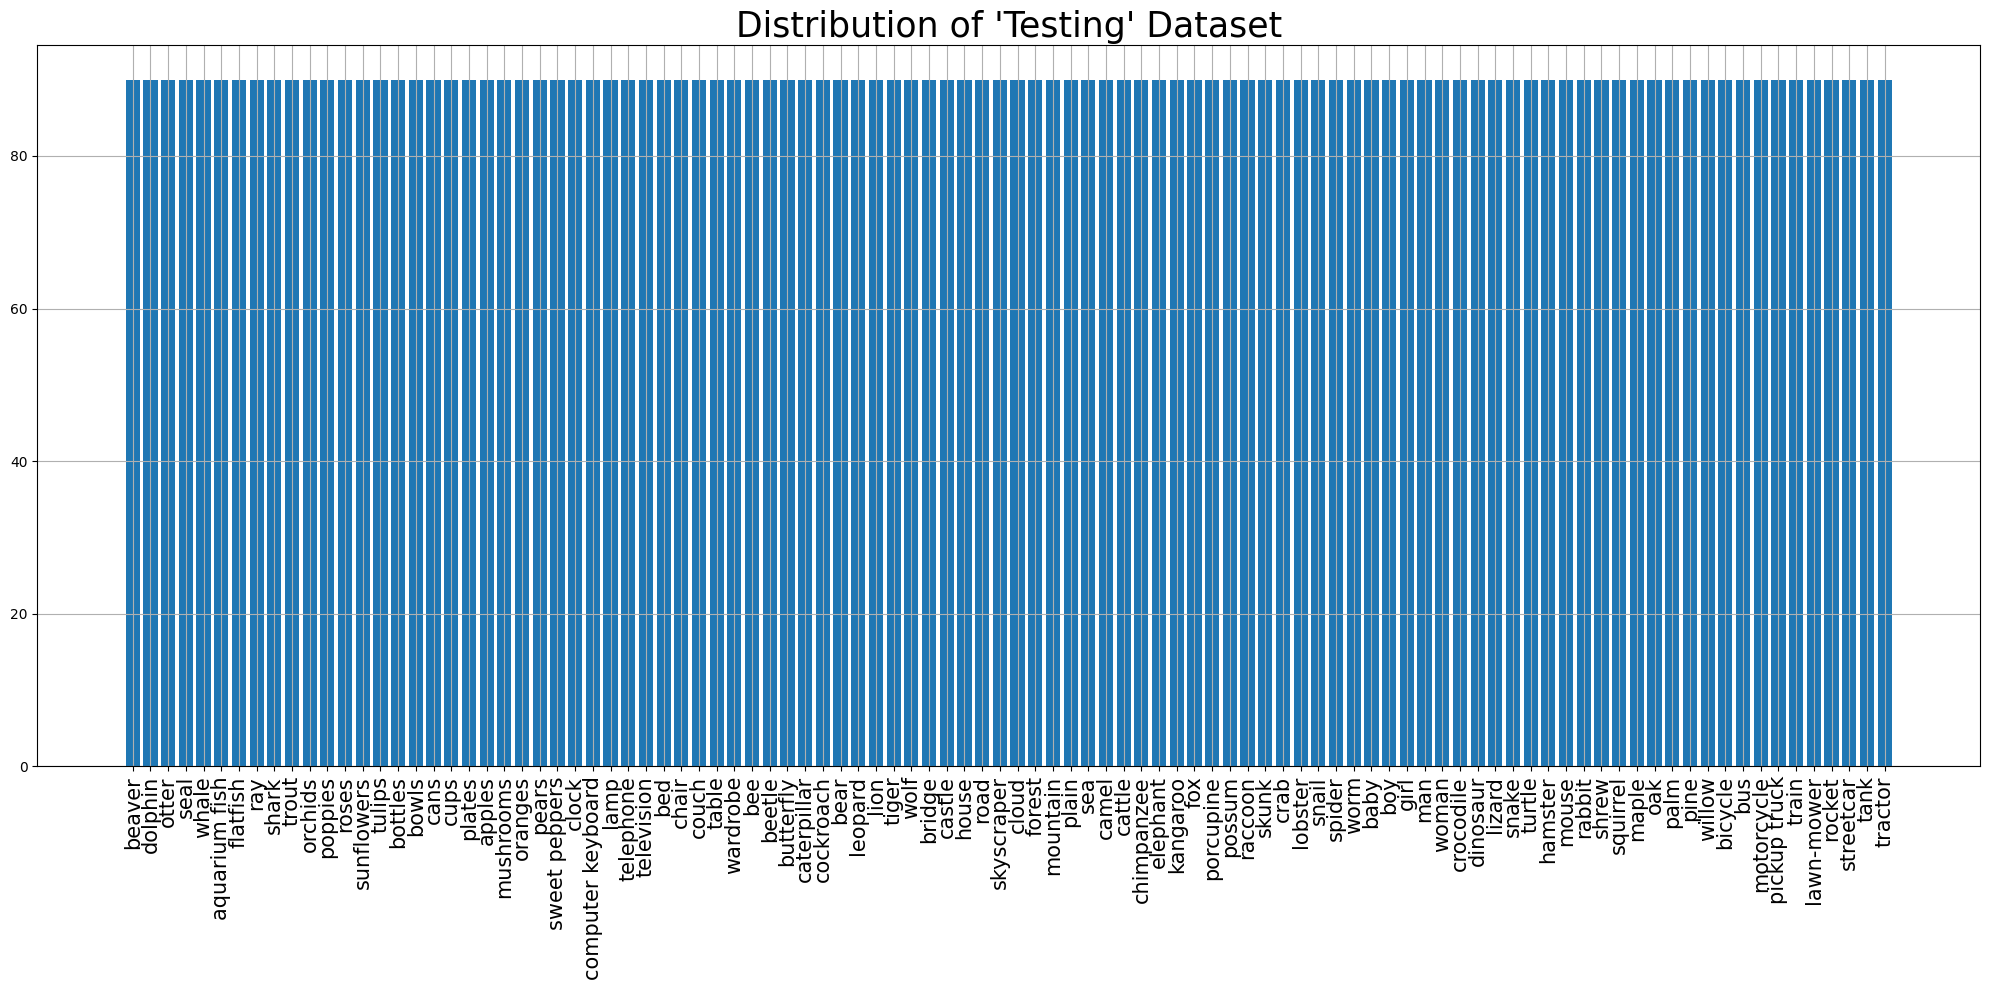

Training dataset:
 <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3248 - f1_score: 0.3191 - loss: 2.8235 - precision: 0.6642
Epoch 1: val_loss improved from inf to 1.47206, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.3248 - f1_score: 0.3192 - loss: 2.8231 - precision: 0.6642 - val_accuracy: 0.5927 - val_f1_score: 0.5906 - val_loss: 1.4721 - val_precision: 0.8248
Epoch 2/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5126 - f1_score: 0.5090 - loss: 1.7989 - precision: 0.7392
Epoch 2: val_loss improved from 1.47206 to 1.39350, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5126 - f1_score: 0.5090 - loss: 1.7988 - precision: 0.7393 - val_accuracy: 0.6089 - val_f1_score: 0.6082 - val_loss: 1.3935 - val_precision: 0.8197
Epoch 3/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5408 - f1_score: 0.5377 - loss: 1.6627 - precision: 0.7511
Epoch 3: val_loss improved fro

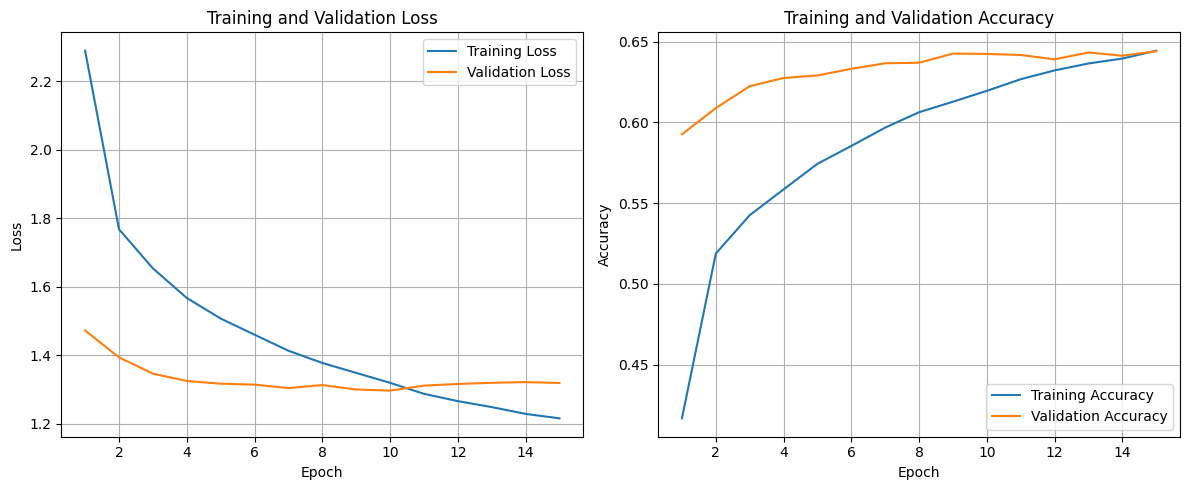

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6289 - f1_score: 0.6183 - loss: 1.3107 - precision: 0.7904
Test Accuracy: 64.31%
Test Loss: 1.2886775732040405
Test Precision: 80.32%
Test F1 Scores (Per Class): [80.74533  75.75757  54.166664 41.428566 32.558136 61.33333  59.999996
 70.520226 81.60919  78.918915 61.53846  42.424236 71.16564  59.171593
 59.999992 61.538452 77.08333  75.64766  54.43787  53.89221  82.22221
 77.34807  79.54544  79.55801  78.30688  60.952377 48.837204 44.554447
 81.31868  62.352936 58.88888  67.02127  52.564095 54.54545  69.61325
 20.96774  69.89246  55.421684 52.41379  90.90909  67.72487  81.52173
 64.       71.8232   46.073296 43.29896  50.574715 53.631275 82.653046
 81.60919  39.234444 70.45454  62.100452 86.33879  71.03825  28.742514
 78.16091  70.46631  76.13636  52.1739   80.       68.29268  71.03825
 61.375652 43.83561  53.503185 65.53671  55.072456 86.666664 84.91619
 71.428566 75.39267  34.636868 55.75757  32.467525 78.172585 83.50515
 58.47

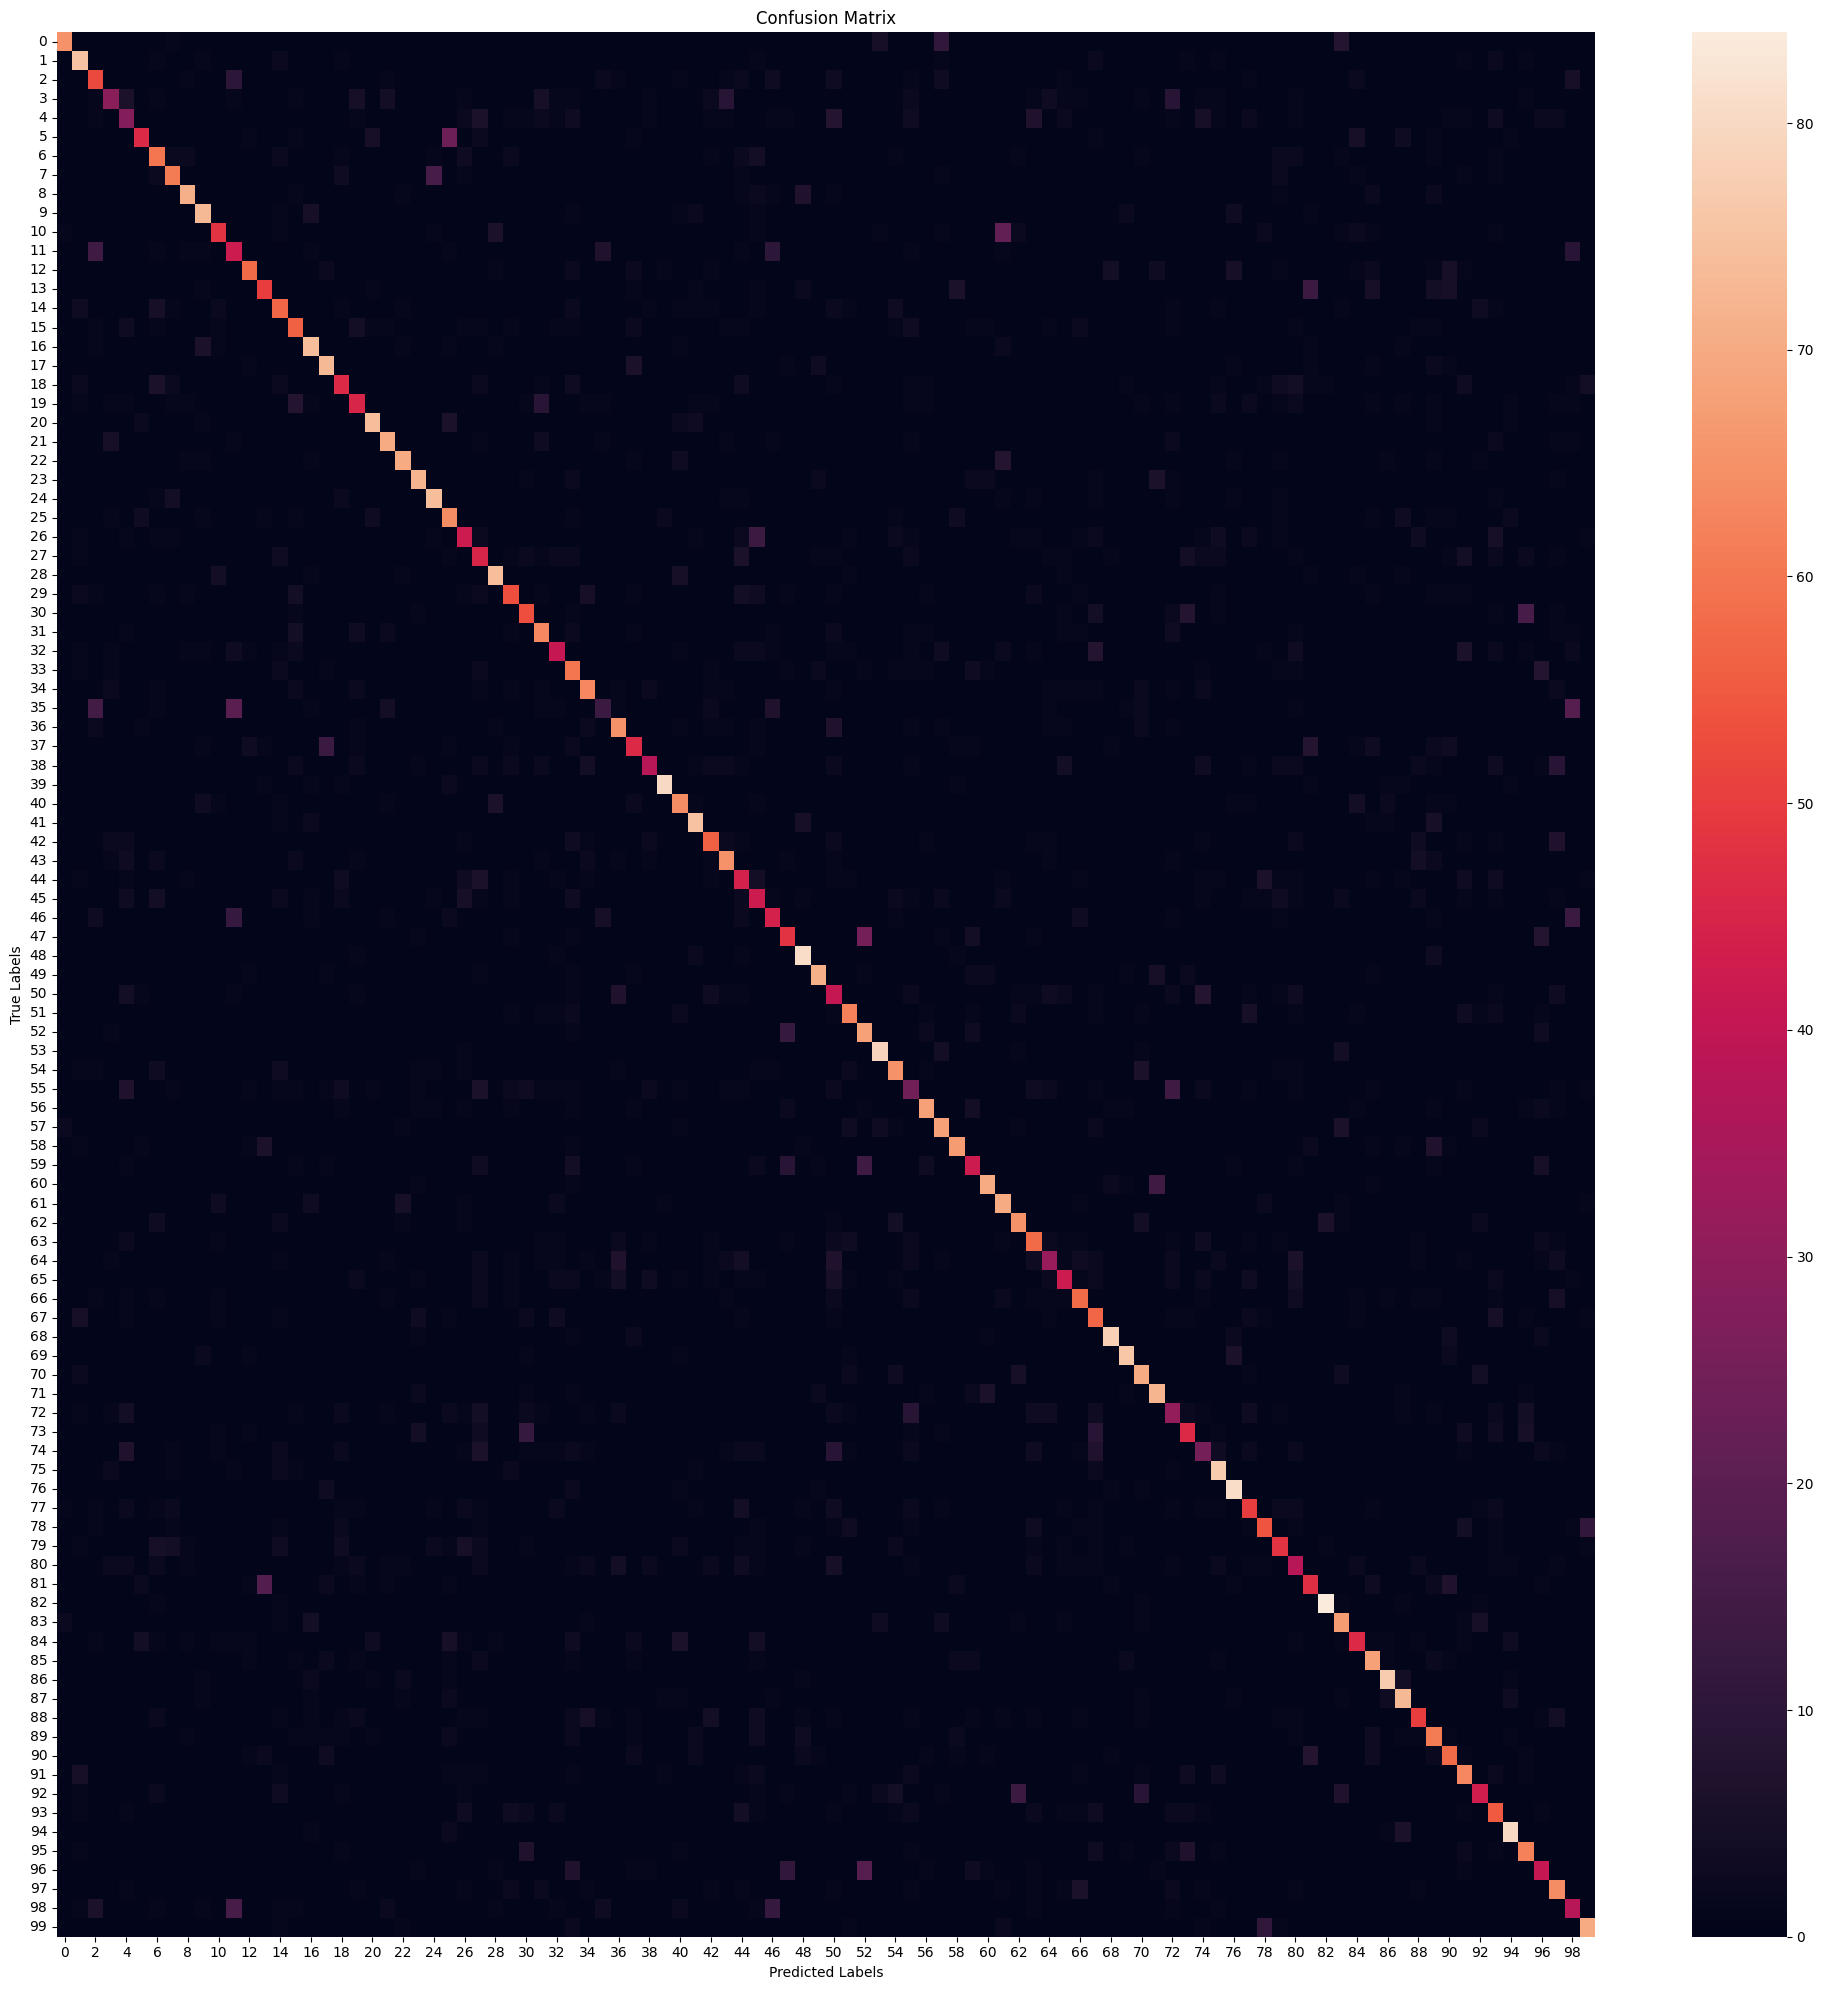

                   precision    recall  f1-score   support

           beaver       0.92      0.72      0.81        90
          dolphin       0.69      0.83      0.76        90
            otter       0.51      0.58      0.54        90
             seal       0.58      0.32      0.41        90
            whale       0.34      0.31      0.33        90
    aquarium fish       0.77      0.51      0.61        90
         flatfish       0.55      0.67      0.60        90
              ray       0.73      0.68      0.71        90
            shark       0.85      0.79      0.82        90
            trout       0.77      0.81      0.79        90
          orchids       0.73      0.53      0.62        90
          poppies       0.39      0.47      0.42        90
            roses       0.79      0.64      0.71        90
       sunflowers       0.63      0.56      0.59        90
           tulips       0.57      0.63      0.60        90
          bottles       0.61      0.62      0.62       

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1970/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6458 - f1_score: 0.6423 - loss: 1.2123 - precision: 0.8088
Epoch 1: val_loss improved from inf to 1.26976, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 73s 31ms/step - accuracy: 0.6458 - f1_score: 0.6423 - loss: 1.2123 - precision: 0.8088 - val_accuracy: 0.6533 - val_f1_score: 0.6513 - val_loss: 1.2698 - val_precision: 0.8061
Epoch 2/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6654 - f1_score: 0.6628 - loss: 1.1321 - precision: 0.8168
Epoch 2: val_loss improved from 1.26976 to 1.26492, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.6654 - f1_score: 0.6628 - loss: 1.1321 - precision: 0.8168 - val_accuracy: 0.6550 - val_f1_score: 0.6533 - val_loss: 1.2649 - val_precision: 0.8024
Epoch 3/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6717 - f1_score: 0.6698 - loss: 1.1001 - precision: 0.8190
Epoch 3: v

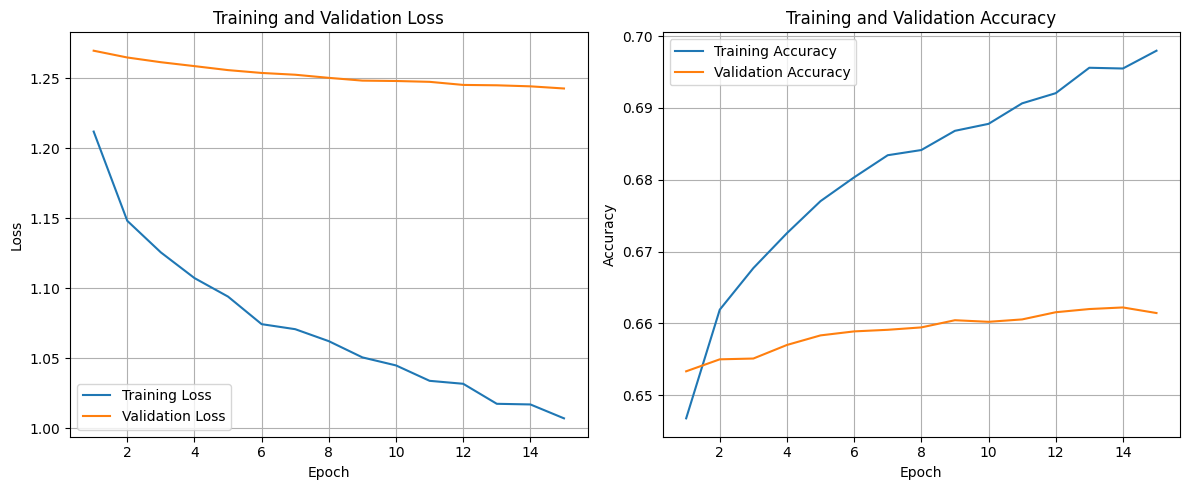

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6501 - f1_score: 0.6414 - loss: 1.2595 - precision: 0.7903
Test Accuracy: 66.28%
Test Loss: 1.2408325672149658
Test Precision: 79.90%
Test F1 Scores (Per Class): [82.285706 79.569885 57.291664 50.27322  37.078648 68.508286 61.306526
 72.625694 83.236984 82.95453  67.816086 54.02298  69.005844 64.24241
 66.27218  61.62162  78.12499  75.13227  59.893044 58.959538 81.11111
 76.43979  80.85106  79.09604  81.52173  64.70587  51.891888 45.63106
 82.22221  64.670654 63.5838   69.005844 57.83132  59.067356 67.75956
 31.818176 71.50838  57.60869  55.172413 90.28571  69.148926 83.33333
 62.983418 74.99999  46.31578  48.42105  48.3146   57.48503  86.02149
 84.090904 42.857136 74.99999  66.99506  87.64044  70.526306 30.120478
 80.473366 71.428566 79.53216  55.555553 80.89887  74.8538   67.04545
 67.85713  42.03821  57.64705  61.290314 54.748596 89.01098  86.95651
 70.85714  74.19354  36.363632 54.838707 37.634407 81.52173  86.666664
 60.1156

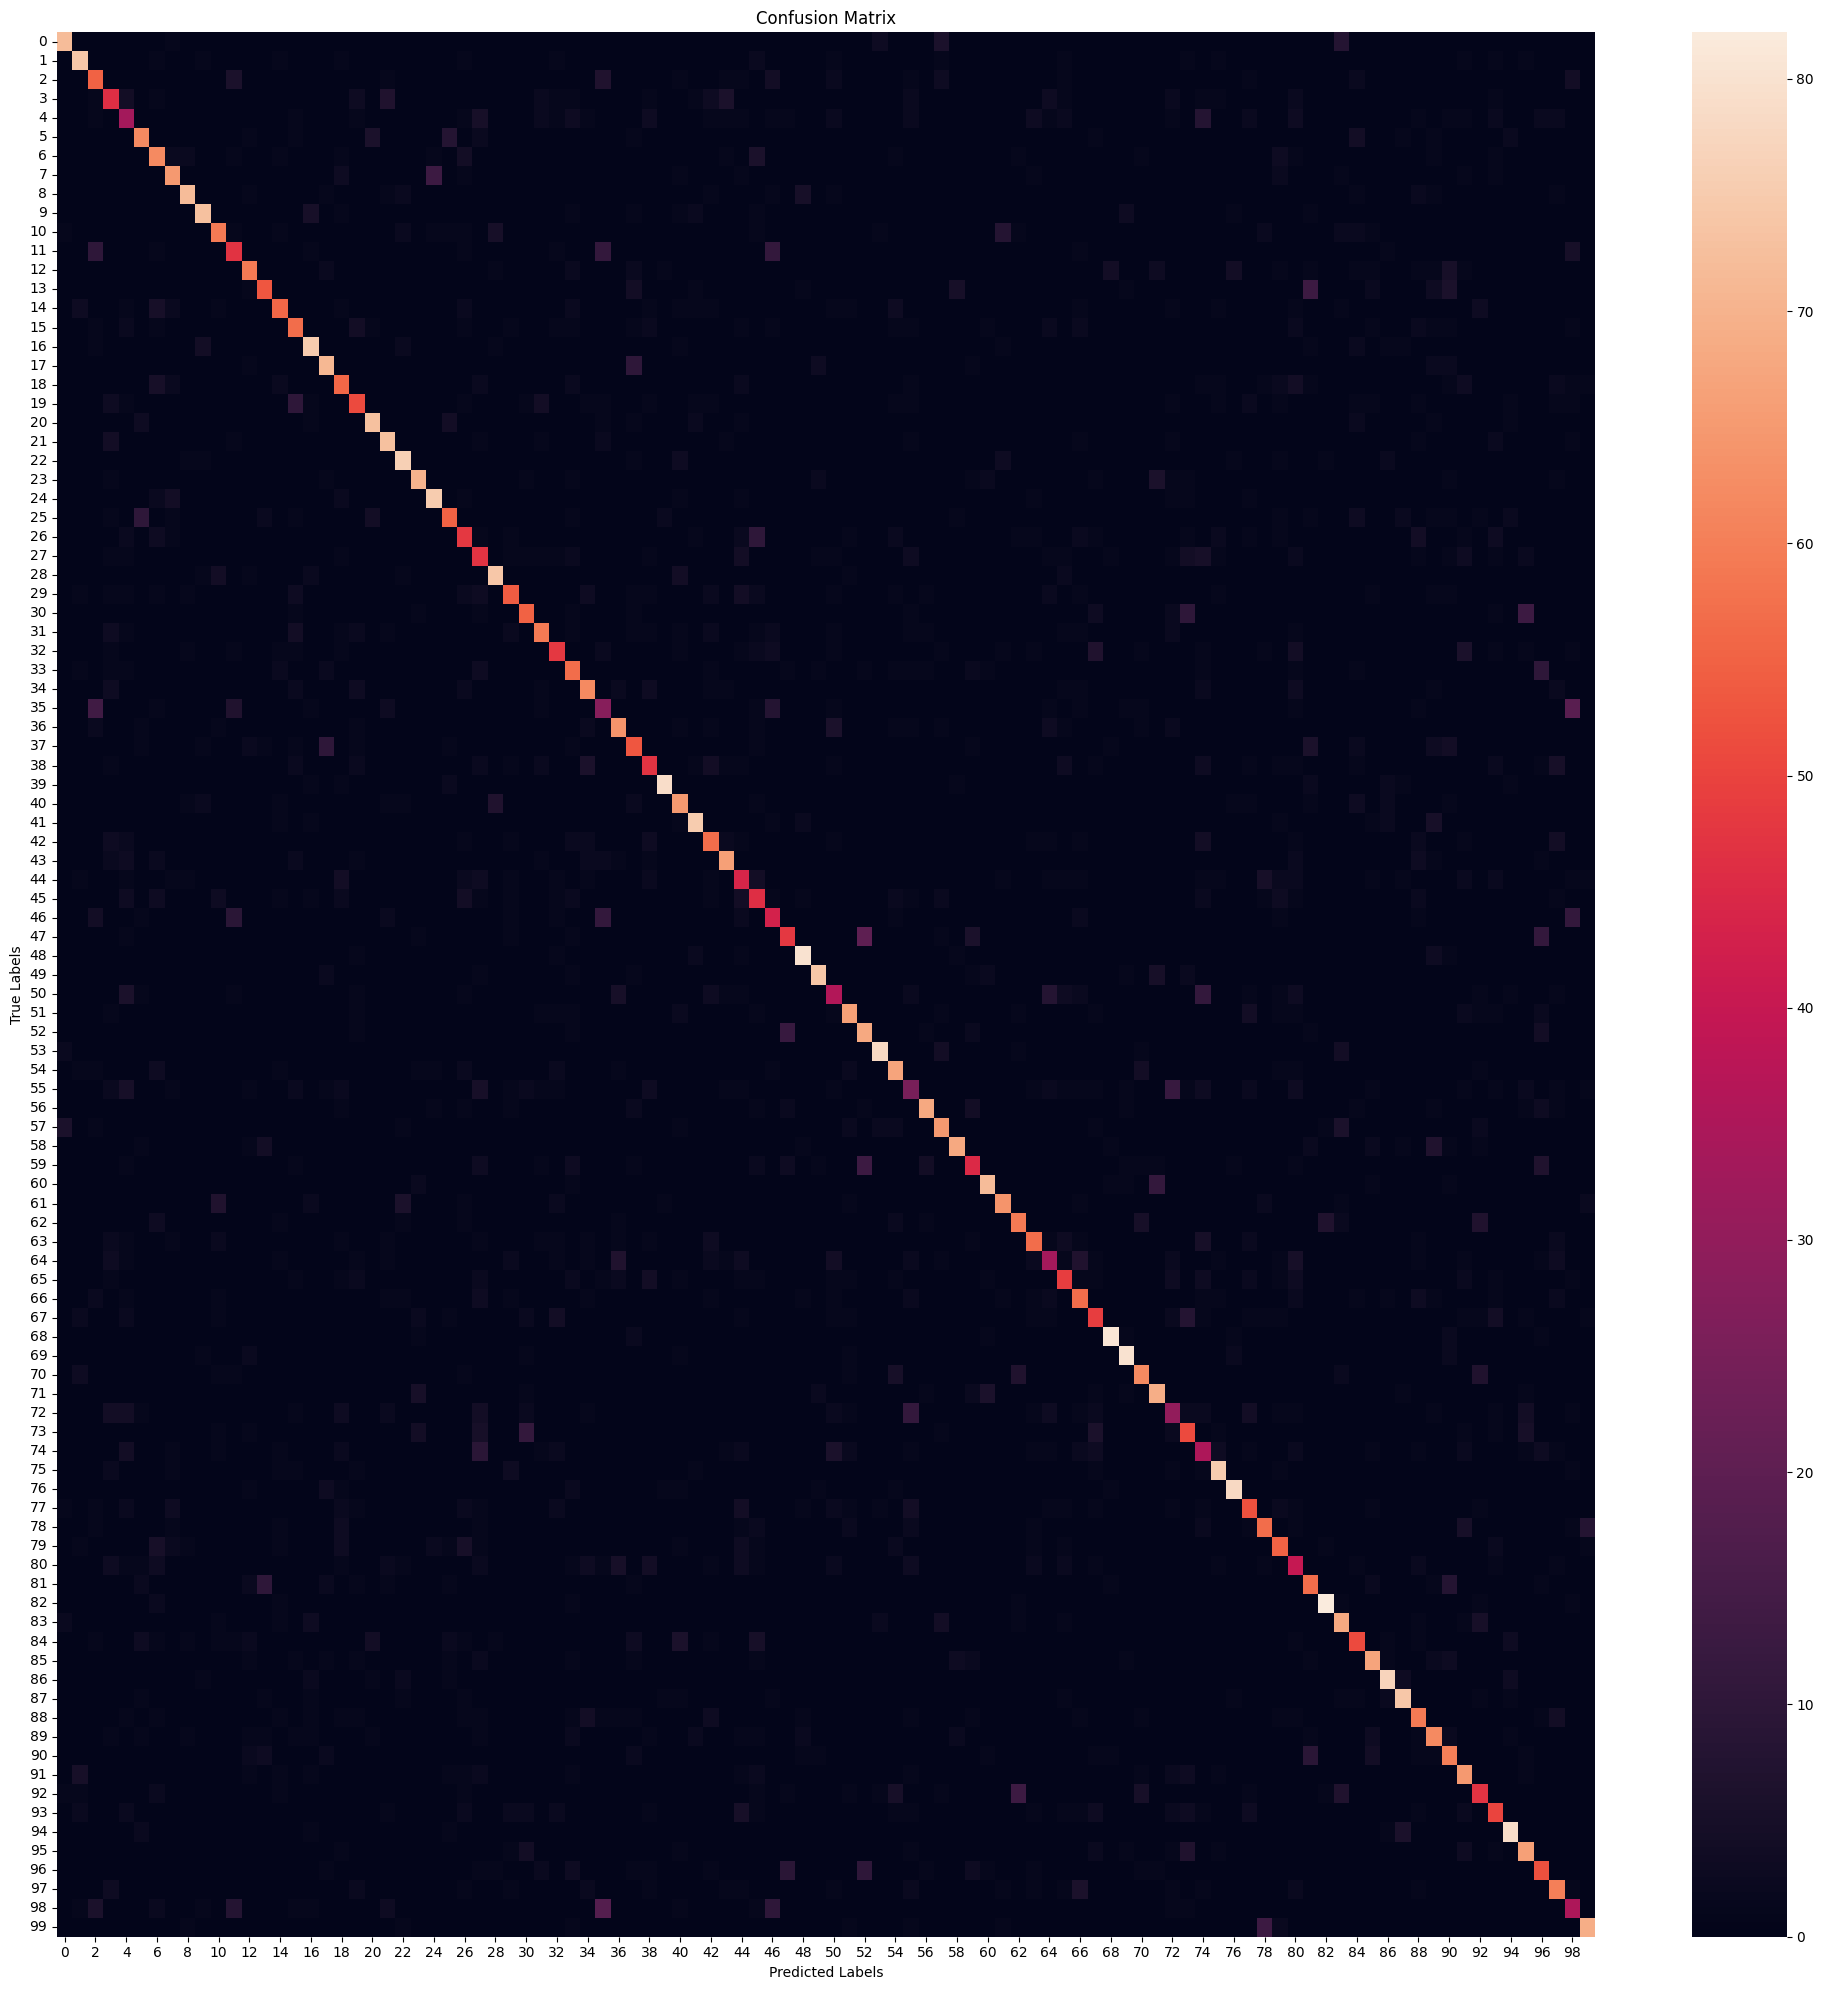

                   precision    recall  f1-score   support

           beaver       0.85      0.80      0.82        90
          dolphin       0.77      0.82      0.80        90
            otter       0.54      0.61      0.57        90
             seal       0.49      0.51      0.50        90
            whale       0.38      0.37      0.37        90
    aquarium fish       0.68      0.69      0.69        90
         flatfish       0.56      0.69      0.62        90
              ray       0.73      0.72      0.73        90
            shark       0.87      0.80      0.83        90
            trout       0.85      0.81      0.83        90
          orchids       0.70      0.66      0.68        90
          poppies       0.56      0.52      0.54        90
            roses       0.73      0.66      0.69        90
       sunflowers       0.71      0.59      0.64        90
           tulips       0.71      0.62      0.66        90
          bottles       0.60      0.63      0.62       

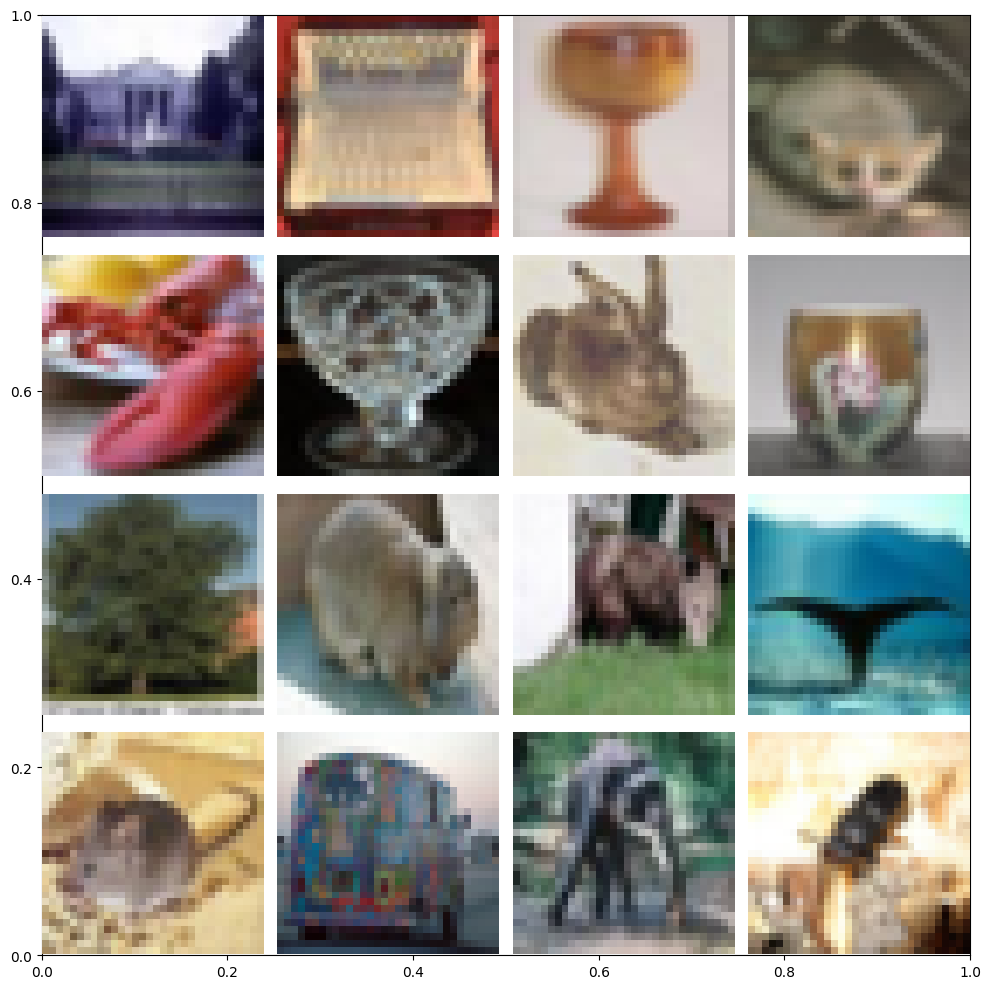

labels[10435].shape: (1,)
imgs[10435].shape: (32, 32, 3)


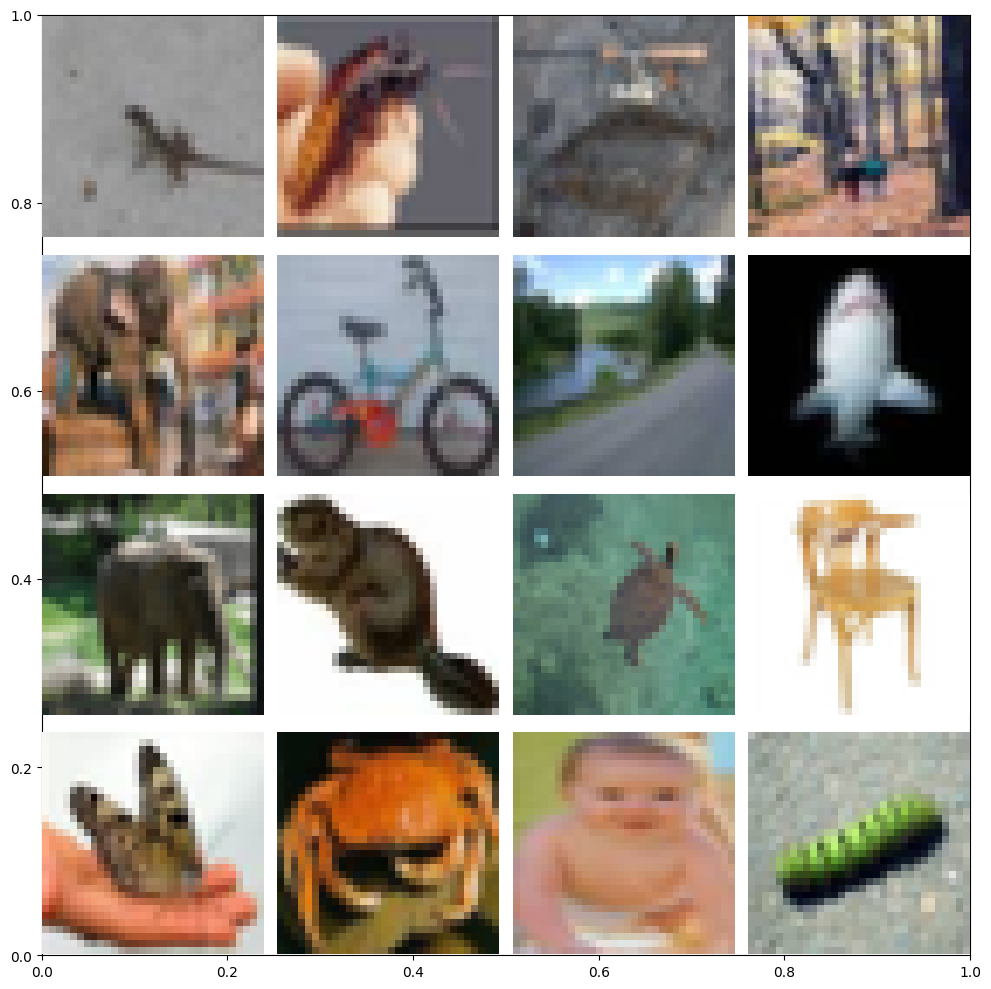

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


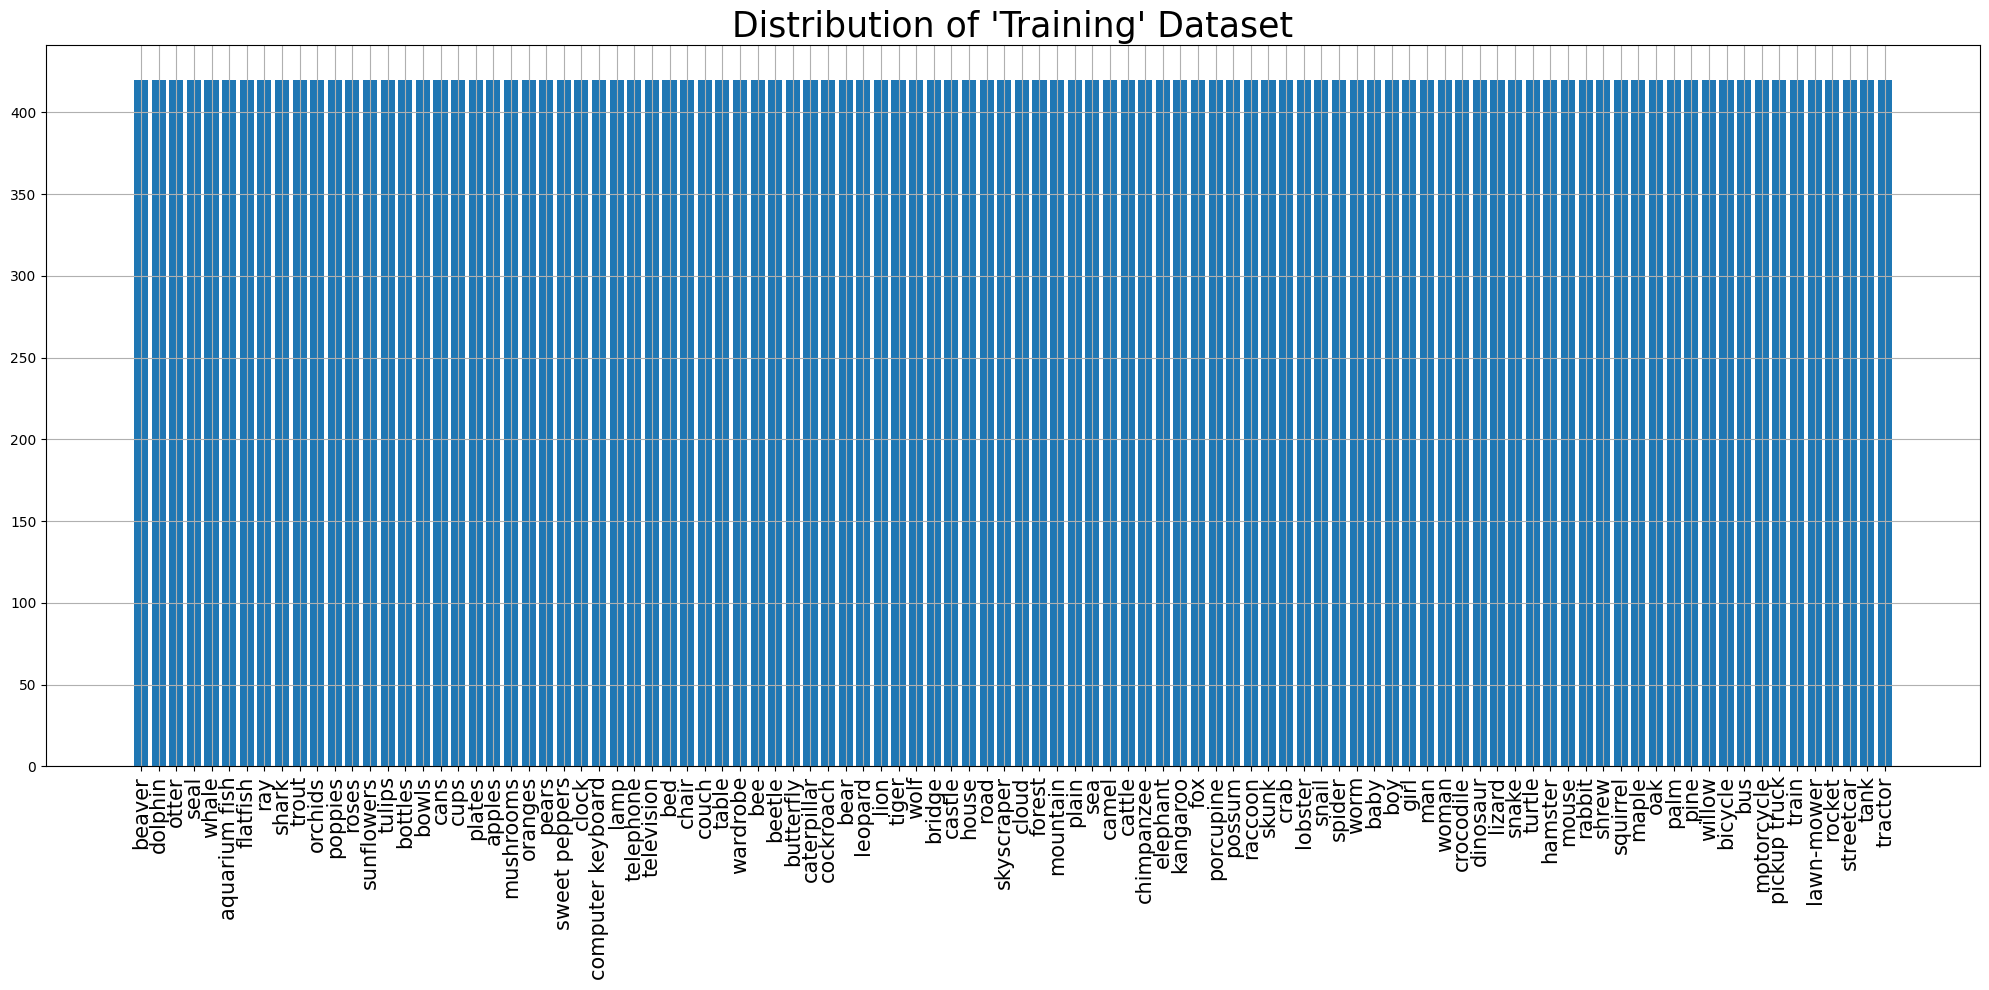

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


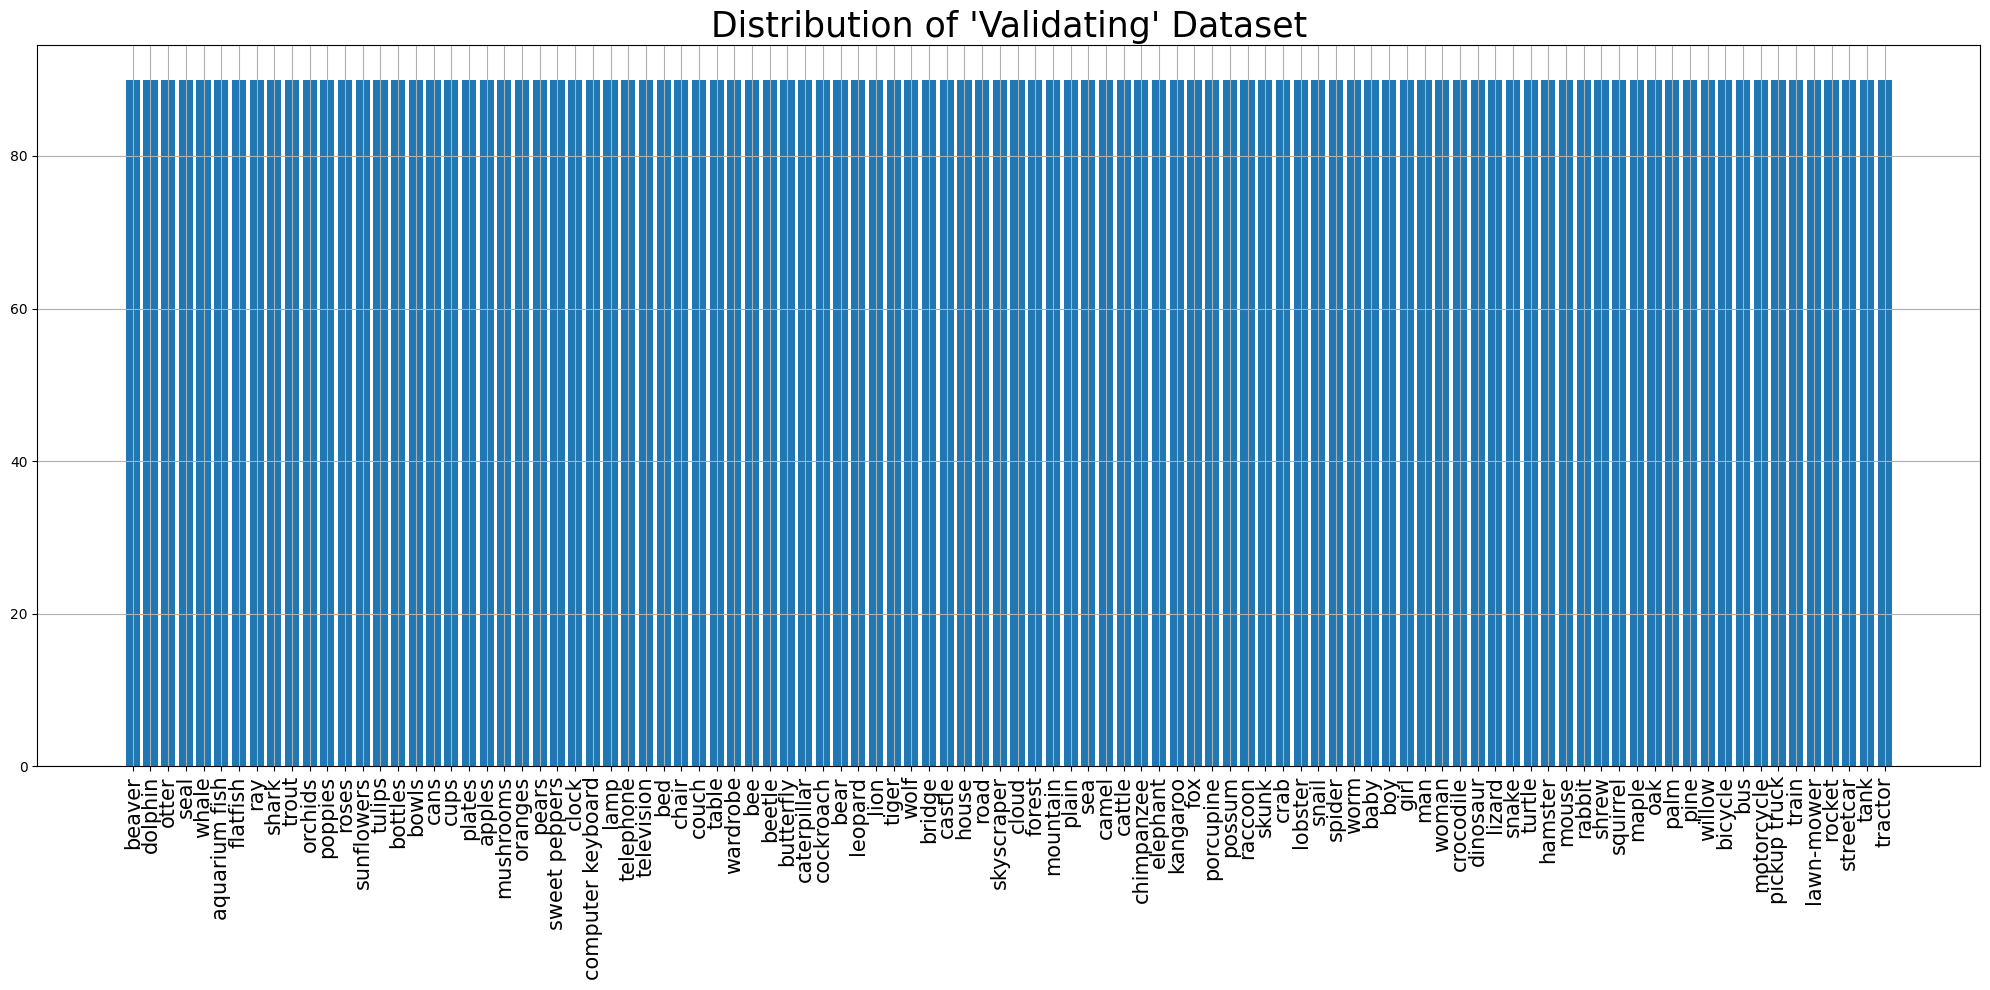

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


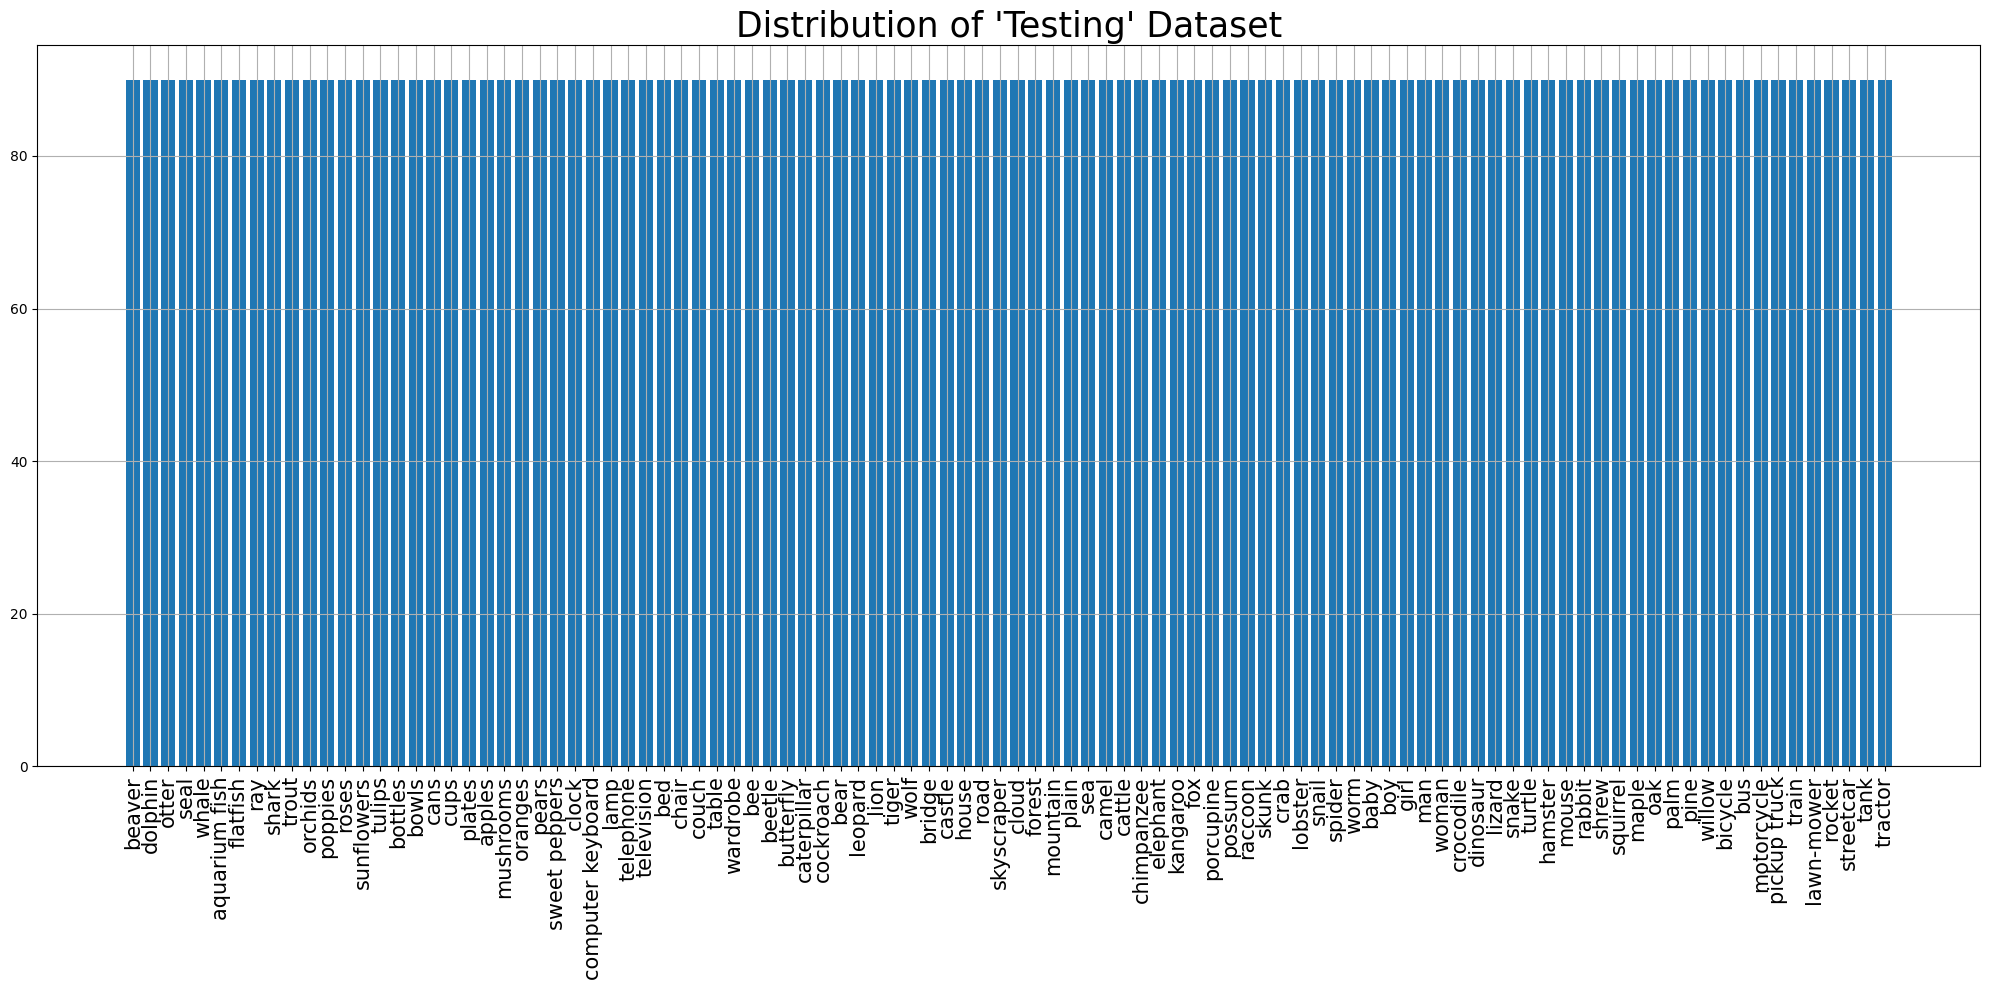

Training dataset:
 <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3316 - f1_score: 0.3258 - loss: 2.7987 - precision: 0.6615
Epoch 1: val_loss improved from inf to 1.45662, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.3316 - f1_score: 0.3259 - loss: 2.7983 - precision: 0.6615 - val_accuracy: 0.5962 - val_f1_score: 0.5915 - val_loss: 1.4566 - val_precision: 0.8142
Epoch 2/25
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5122 - f1_score: 0.5084 - loss: 1.7962 - precision: 0.7352
Epoch 2: val_loss improved from 1.45662 to 1.37898, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5122 - f1_score: 0.5084 - loss: 1.7961 - precision: 0.7352 - val_accuracy: 0.6131 - val_f1_score: 0.6097 - val_loss: 1.3790 - val_precision: 0.8242
Epoch 3/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5469 - f1_score: 0.5436 - loss: 1.6426 - precision: 0.7561
Epoch 3: val_loss improved fro

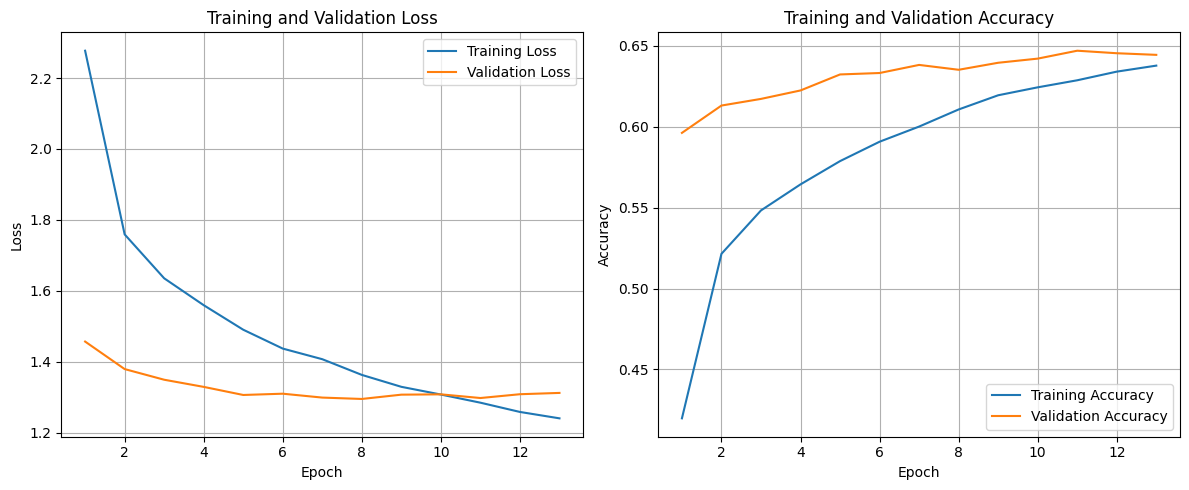

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6260 - f1_score: 0.6189 - loss: 1.3173 - precision: 0.7930
Test Accuracy: 63.57%
Test Loss: 1.2967246770858765
Test Precision: 80.34%
Test F1 Scores (Per Class): [85.22727  75.49018  45.390064 41.290318 38.19095  65.89595  57.868015
 69.23077  82.142845 82.71605  69.18238  47.27272  63.855415 60.21505
 65.771805 57.64705  81.44328  73.68421  59.7826   56.6265   82.285706
 76.300575 80.21977  78.82352  82.285706 61.375652 47.422672 36.448593
 76.50272  65.19337  55.6962   64.86485  49.42528  56.744183 60.60605
 26.027393 66.29213  50.7177   45.161285 90.39548  68.852455 79.12087
 58.620686 70.83333  51.578945 46.15384  49.999992 54.143642 80.89887
 81.39534  37.209297 72.16493  60.696507 86.18784  68.926544 31.111107
 80.       69.36415  75.30864  53.012043 80.66298  72.43243  63.5838
 66.25     42.04545  50.649338 62.41134  51.72413  87.17948  80.446915
 68.04123  74.074066 37.569054 56.382973 37.254898 81.11111  84.32432
 53.631

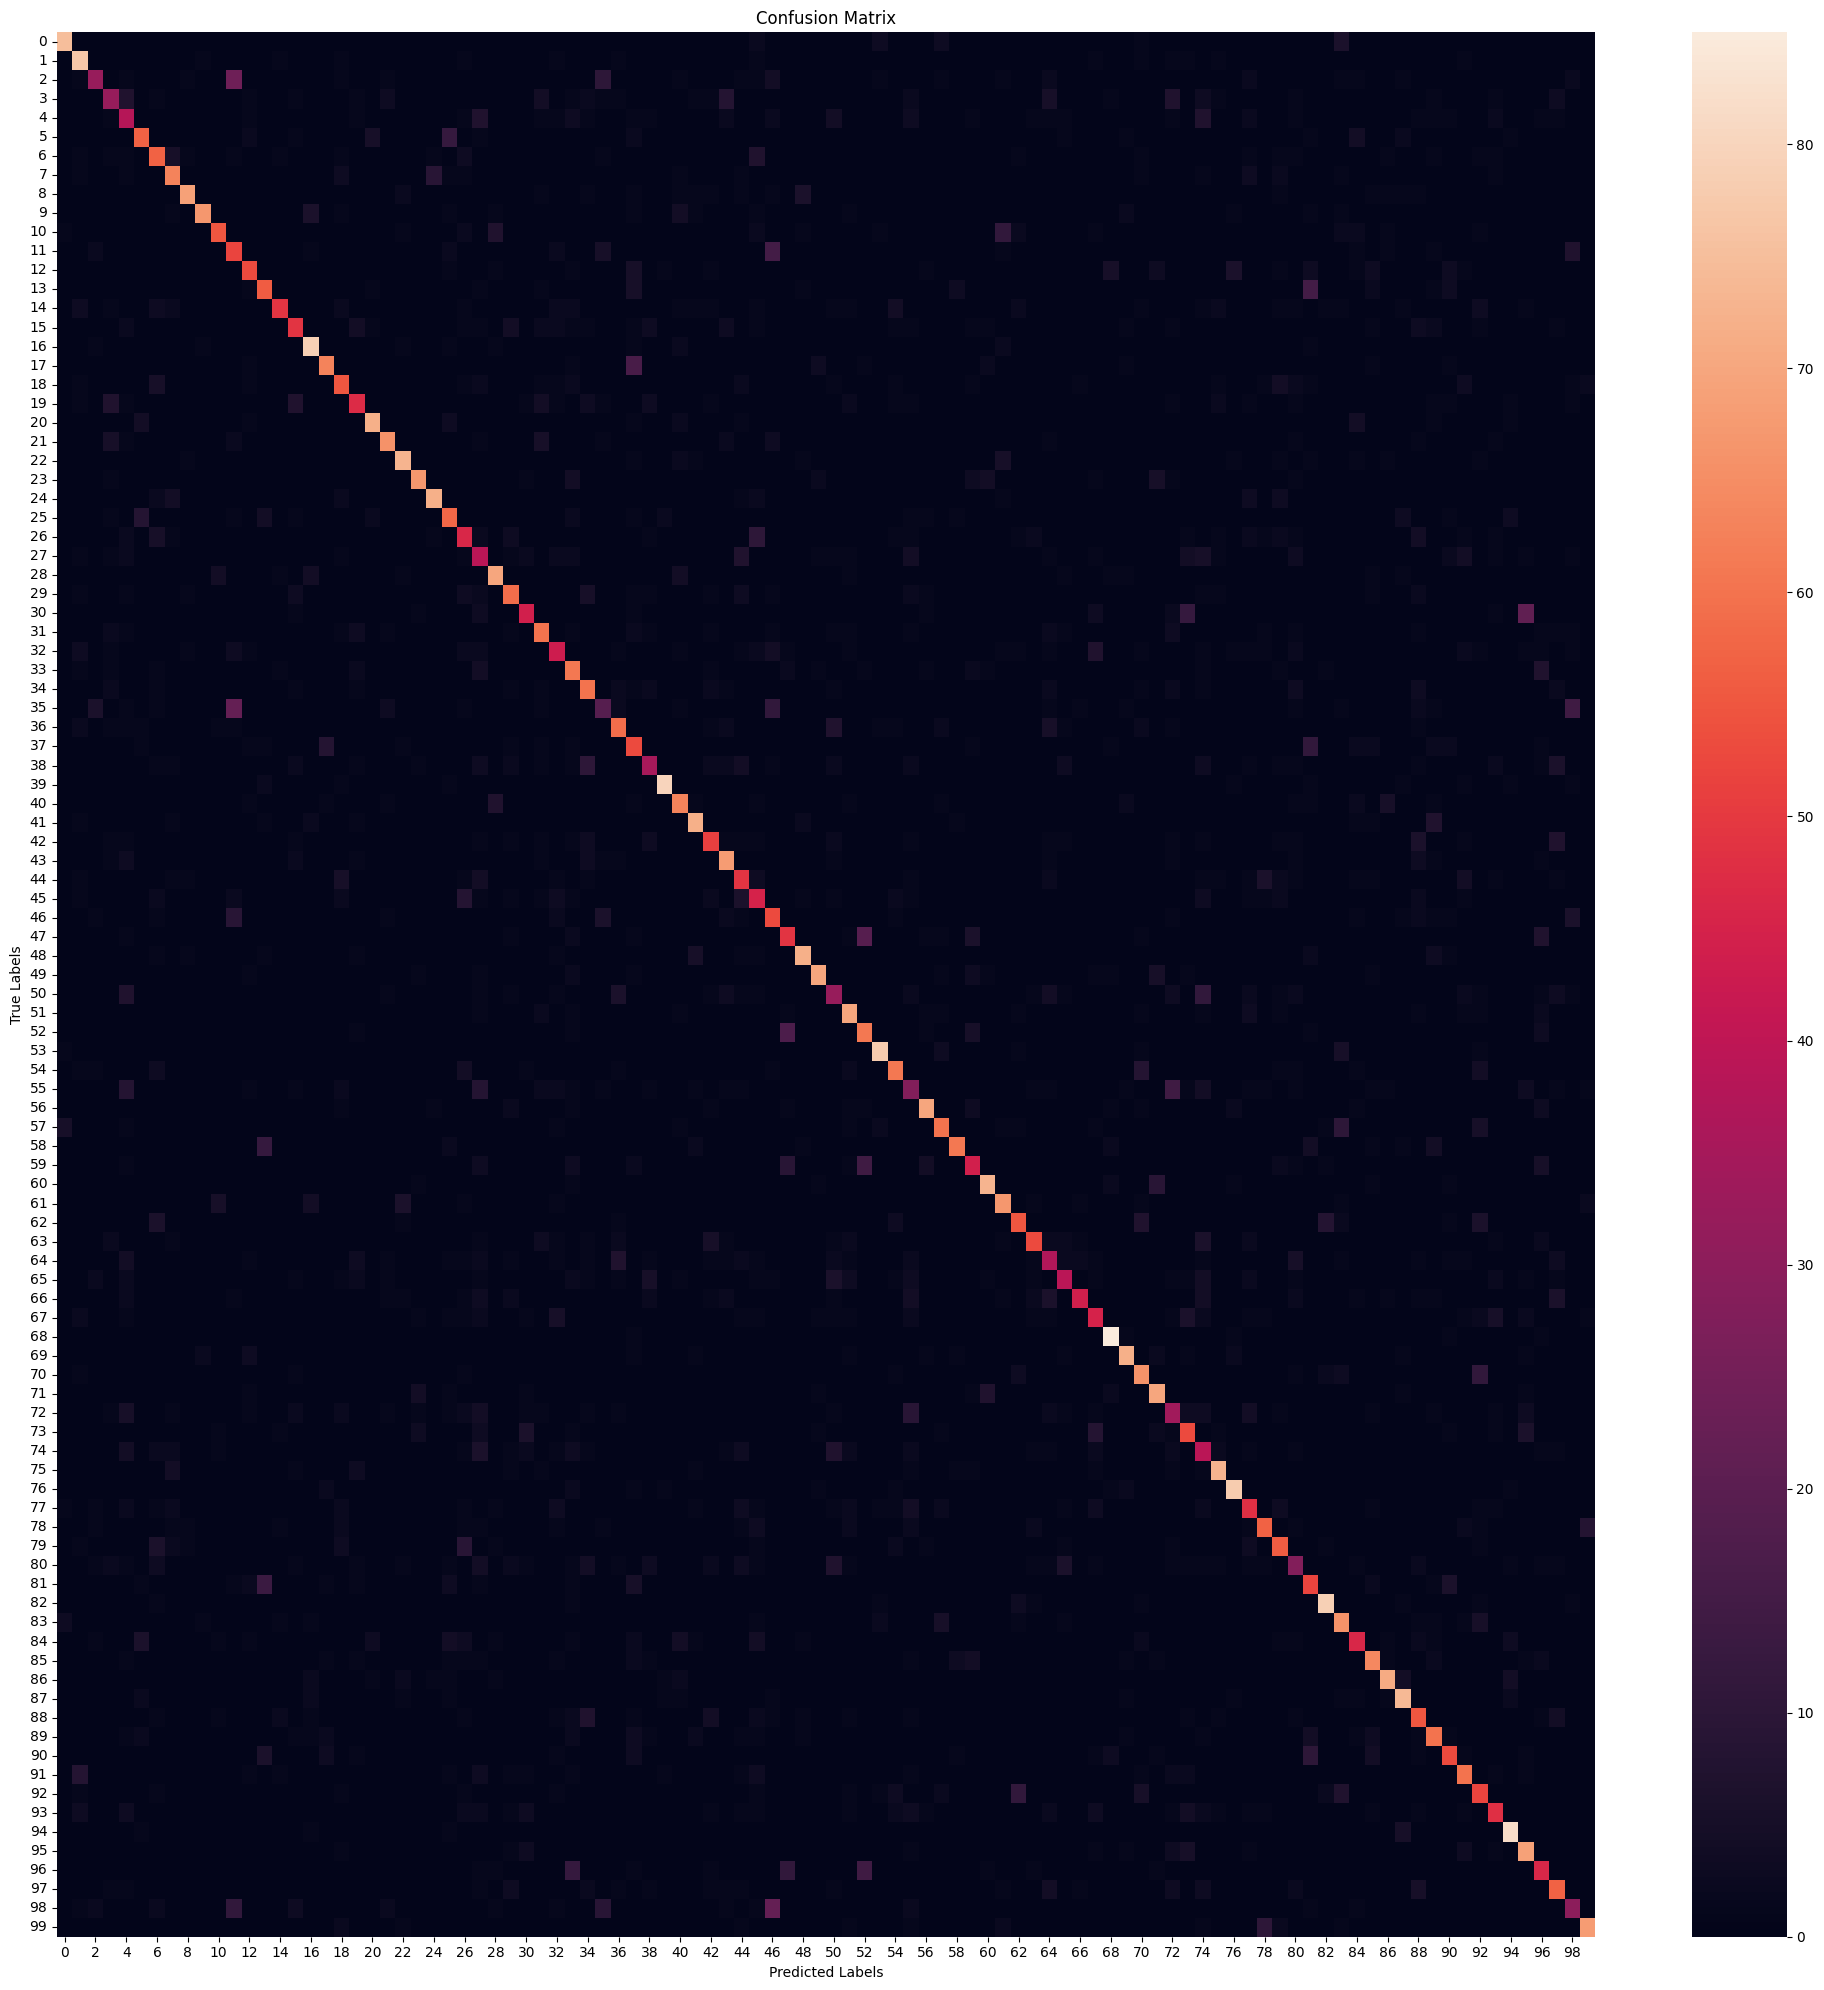

                   precision    recall  f1-score   support

           beaver       0.87      0.83      0.85        90
          dolphin       0.68      0.86      0.75        90
            otter       0.63      0.36      0.45        90
             seal       0.49      0.36      0.41        90
            whale       0.35      0.42      0.38        90
    aquarium fish       0.69      0.63      0.66        90
         flatfish       0.53      0.63      0.58        90
              ray       0.68      0.70      0.69        90
            shark       0.88      0.77      0.82        90
            trout       0.93      0.74      0.83        90
          orchids       0.80      0.61      0.69        90
          poppies       0.40      0.58      0.47        90
            roses       0.70      0.59      0.64        90
       sunflowers       0.58      0.62      0.60        90
           tulips       0.83      0.54      0.66        90
          bottles       0.61      0.54      0.58       

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6336 - f1_score: 0.6320 - loss: 1.2577 - precision: 0.7988
Epoch 1: val_loss improved from inf to 1.26642, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 72s 31ms/step - accuracy: 0.6336 - f1_score: 0.6320 - loss: 1.2577 - precision: 0.7988 - val_accuracy: 0.6477 - val_f1_score: 0.6470 - val_loss: 1.2664 - val_precision: 0.8087
Epoch 2/15
1970/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6532 - f1_score: 0.6513 - loss: 1.1760 - precision: 0.8138
Epoch 2: val_loss improved from 1.26642 to 1.26203, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.6532 - f1_score: 0.6513 - loss: 1.1761 - precision: 0.8138 - val_accuracy: 0.6511 - val_f1_score: 0.6505 - val_loss: 1.2620 - val_precision: 0.8076
Epoch 3/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6665 - f1_score: 0.6645 - loss: 1.1375 - precision: 0.8177
Epoch 3: v

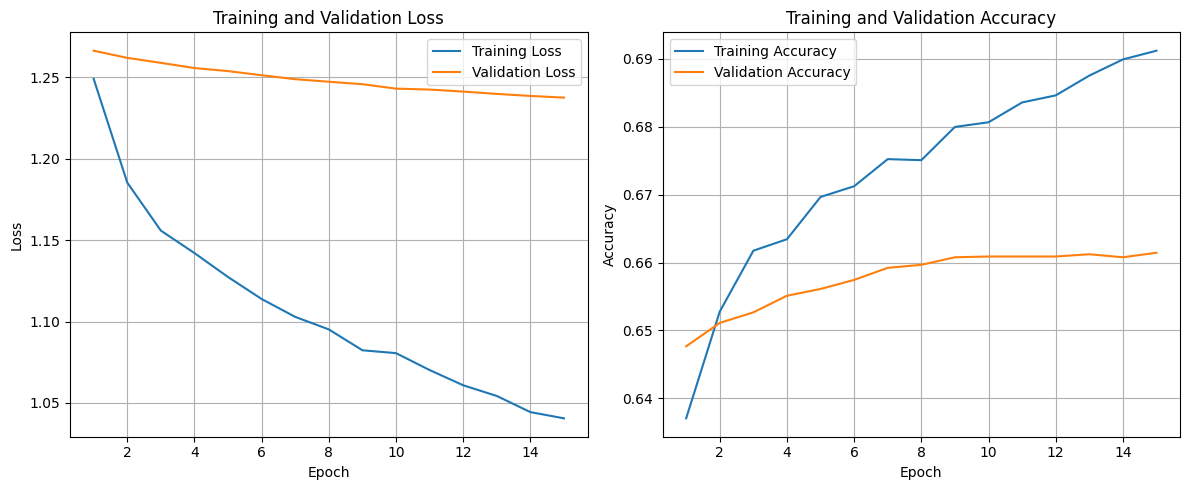

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6479 - f1_score: 0.6408 - loss: 1.2601 - precision: 0.7880
Test Accuracy: 65.73%
Test Loss: 1.2411272525787354
Test Precision: 80.14%
Test F1 Scores (Per Class): [84.91619  76.28865  52.747242 46.92737  41.62436  70.05649  62.376225
 67.40331  80.722885 81.437126 65.89595  47.499996 62.427734 61.9883
 69.87952  59.7826   80.628265 75.93583  58.333324 60.24096  80.66298
 78.12499  76.756744 77.77777  81.767944 65.19337  51.764698 42.156857
 76.92307  66.66666  63.157898 70.303024 49.999992 59.29648  67.0391
 33.142853 71.73912  57.14285  46.99453  91.95402  68.42105  82.872925
 62.365585 71.99999  51.933693 49.999992 49.438198 56.6265   80.43478
 82.02247  40.96385  74.157295 63.541664 88.52458  68.71794  36.55913
 81.6568   70.45454  80.23255  53.08641  80.681816 73.14285  68.06282
 70.58823  44.57831  56.818176 64.04494  58.24175  87.29281  84.32432
 69.36415  75.53191  41.176464 57.303364 38.251358 82.22221  86.95651
 57.80347 

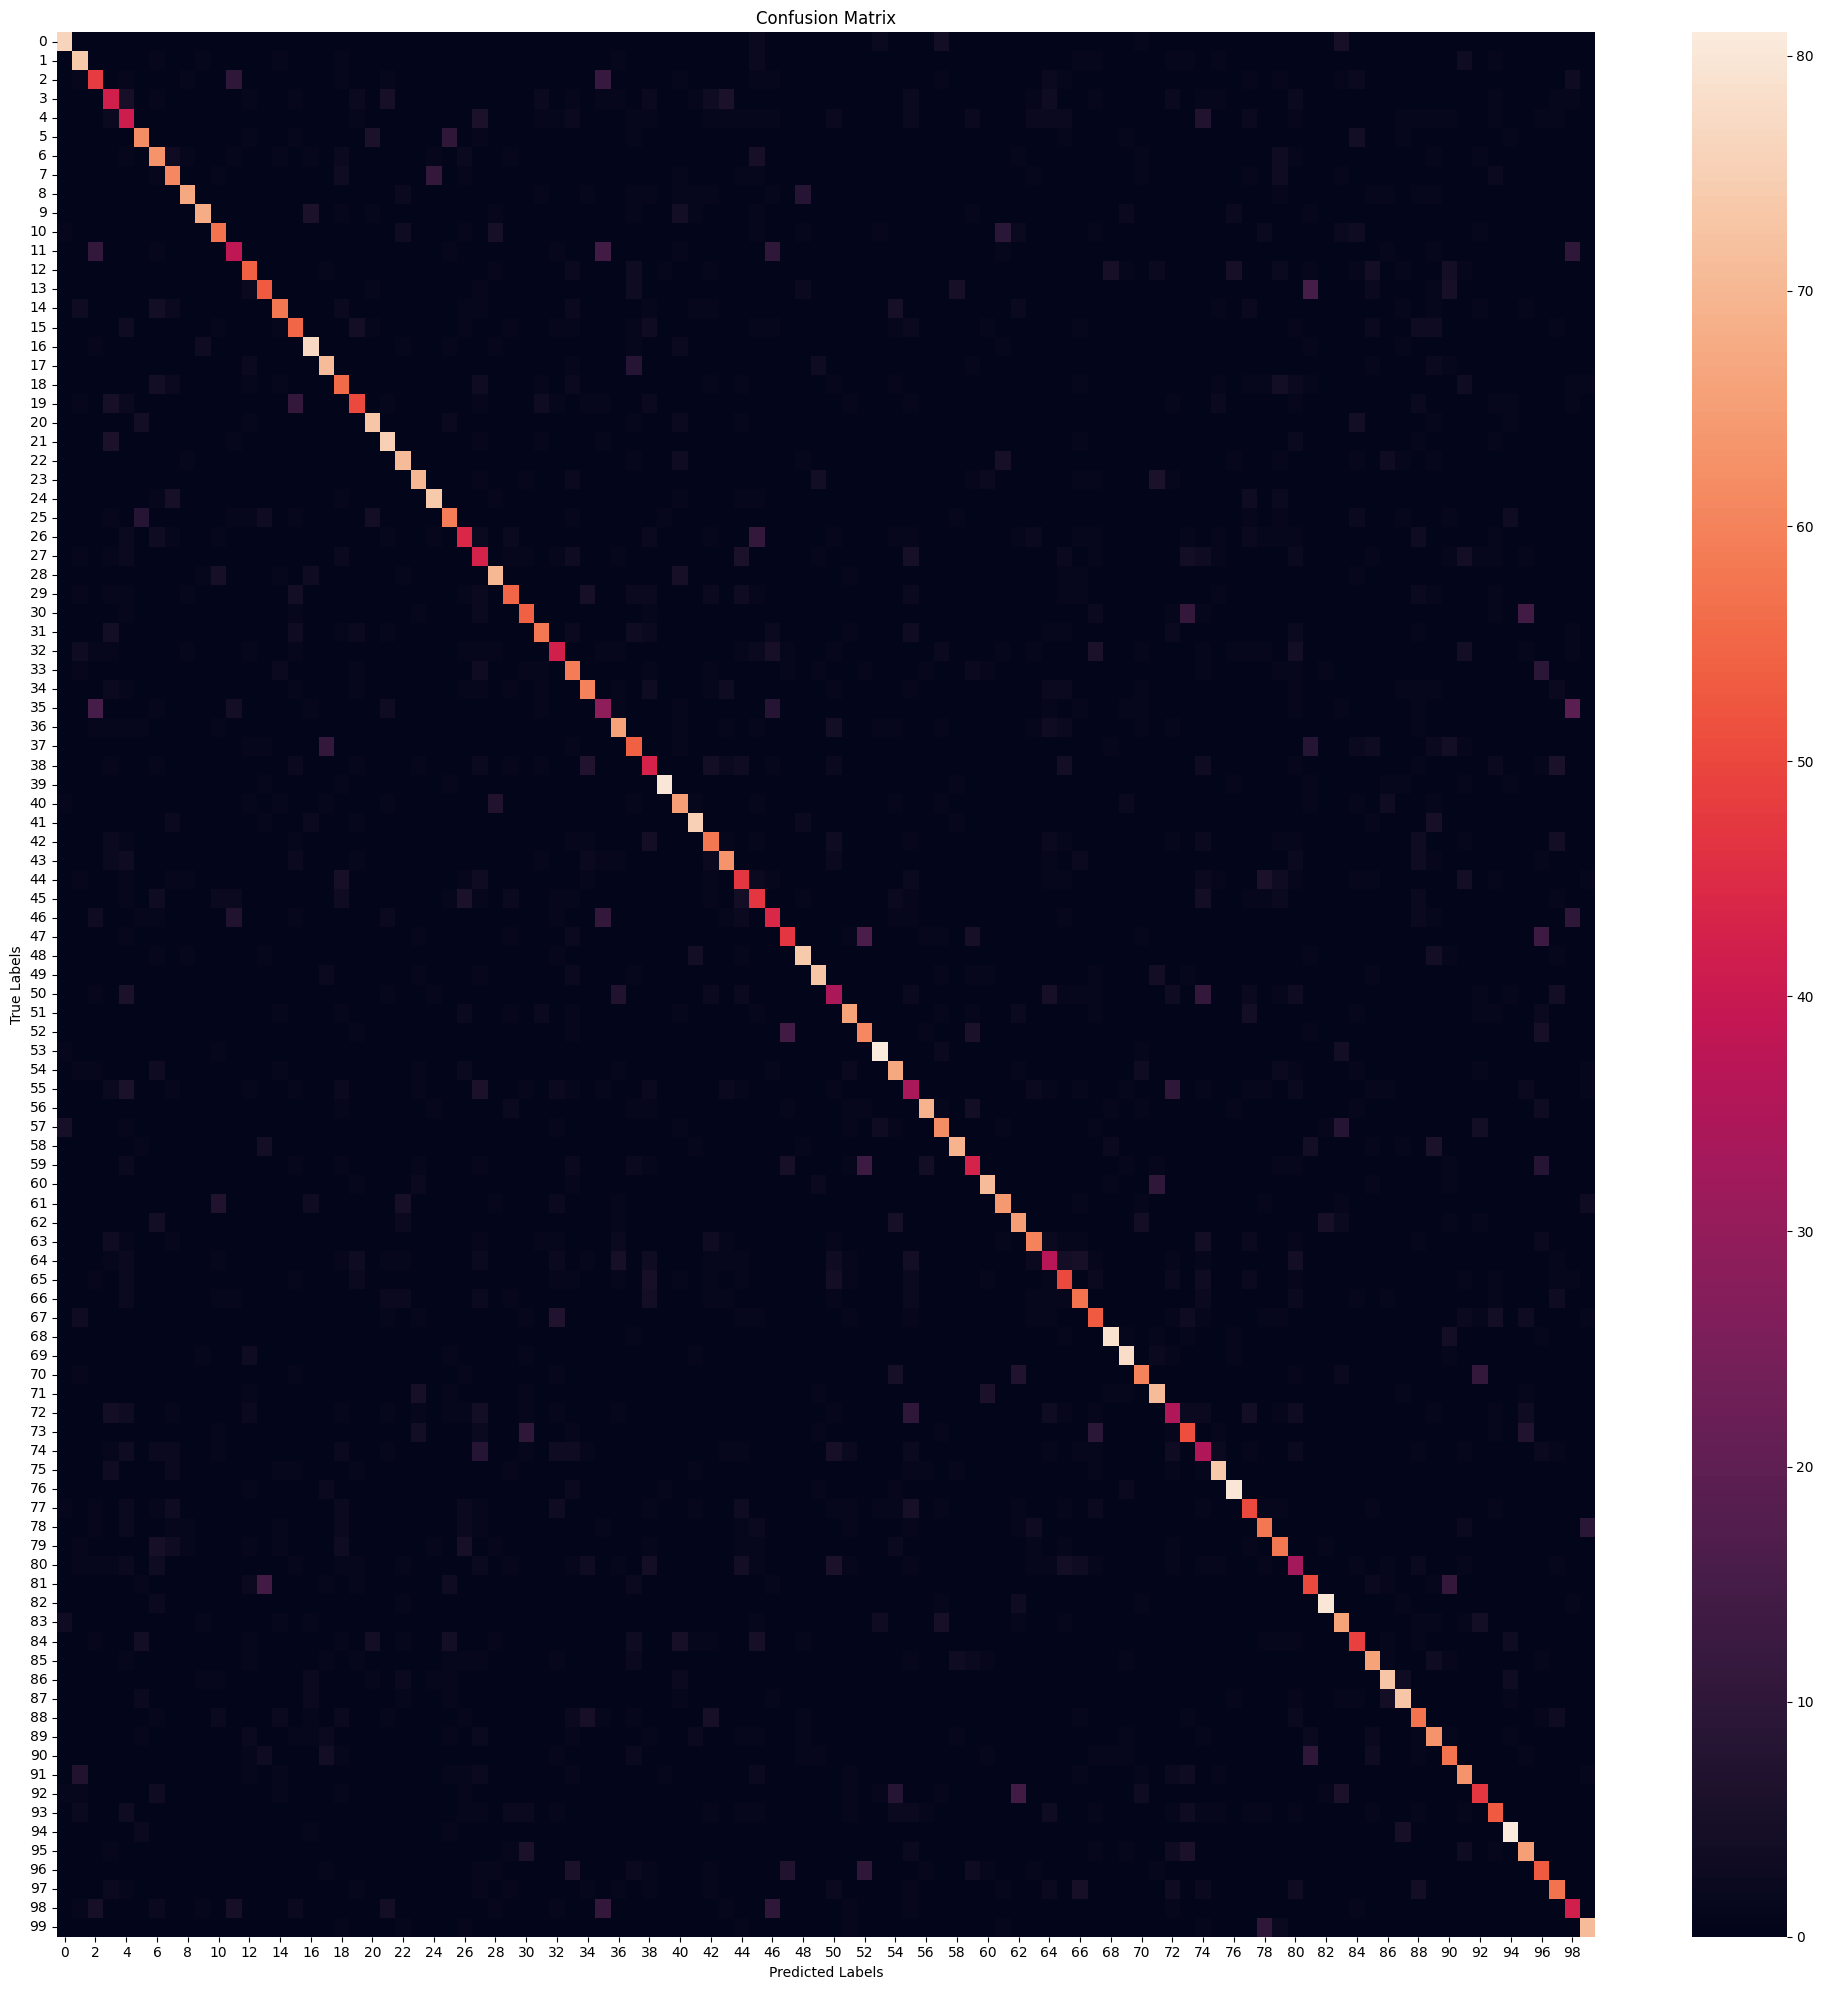

                   precision    recall  f1-score   support

           beaver       0.85      0.84      0.85        90
          dolphin       0.71      0.82      0.76        90
            otter       0.52      0.53      0.53        90
             seal       0.47      0.47      0.47        90
            whale       0.38      0.46      0.42        90
    aquarium fish       0.71      0.69      0.70        90
         flatfish       0.56      0.70      0.62        90
              ray       0.67      0.68      0.67        90
            shark       0.88      0.74      0.81        90
            trout       0.88      0.76      0.81        90
          orchids       0.69      0.63      0.66        90
          poppies       0.54      0.42      0.47        90
            roses       0.65      0.60      0.62        90
       sunflowers       0.65      0.59      0.62        90
           tulips       0.76      0.64      0.70        90
          bottles       0.59      0.61      0.60       

In [6]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64

    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_.concatenate(train_dataset_aug)

    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(3e-1) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.7), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-2), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model_v3.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune_v3.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model_v3.keras')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune_v3.keras')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist